# Epymorph dev log: May 31, 2023

Author: Alexander Nez

as of git hash:

### Social Determinate of Health (sdh)

### sdh toml params

infection_duration = 4.0

immunity_duration = 90.0

infection_seed_loc = 2451

infection_seed_size = 9708

hospitalization_duration = 5.3

alpha = [0.05, 0.4125, 0.5875]

gamma = 0.1000022

phi = 40



# sdh with pei movement

### plots sdh model by prevalence
python -m epymorph run --ipm sdh --mm centroids --geo maricopa_cbg_2019 --params "./scratch/params/sdh_params.toml" --start_date "2015-01-01" --duration "150d" --chart "p0" --out ./scratch/output_files/sdh.csv 
### creates sirh_sdh
python -m epymorph run --ipm sdh --mm centroids --geo maricopa_cbg_2019 --params ./scratch/params/sdh_params.toml --start_date 2015-01-01 --duration 150d --out ./scratch/output_files/sdh.csv  

In [186]:
from epymorph.run import run
from epymorph.data.ipm.initializer import BottomLocsInitializer, IndexedLocsInitializer, LabeledLocsInitializer, RandomLocsInitializer, TopLocsInitializer
from epymorph.data import geo_library, ipm_library, mm_library
from epymorph.data.ipm.sdh import sirhBuilder as SdhBuilder
from epymorph.simulation import Simulation
from epymorph.world import Population 
from epymorph.run import save_csv

from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.spatial.distance import squareform
from numpy.typing import DTypeLike, NDArray
from shapely.geometry import Point, Polygon
from scipy.spatial.distance import pdist
from IPython.core.display import SVG
from matplotlib.pyplot import xlabel
from scipy.optimize import minimize
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
from scipy.stats import norm
from datetime import date
import geopandas as gpd
from numpy import size
import seaborn as sns
import pandas as pd
import numpy as np
import pydot
import time
import os

with np.load(f"./epymorph/data/geo/maricopa_cbg_2019_geo.npz") as npz_data:
        data = dict(npz_data)

%matplotlib inline

dir = os.path.expanduser('~/Desktop/Github/Epymorph/scratch')

sdh_df = pd.DataFrame({k: list(v) for k, v in data.items()})
lat_lon_df = pd.DataFrame(sdh_df["centroid"].to_list(), columns=['Lon', 'Lat'])

In [ ]:
'04_013_1058'

In [40]:
sdh_df.head()

,labels,population,centroid,median_age,pop_by_age,median_income,total_income,average_household_size,pop_density_km2,tract_median_income,...,gamma 0,count,x1,x2,h1,h2,beta,alpha 0,alpha 1,alpha 2
0,040130101011,1791,"[-111.770772219983, 33.7692433720249]",50.5,"[358, 110, 671, 374, 194, 84]",99219,90125800,2.33,99.301764,99489,...,0.01,1,-0.596410,-1.219544,0.795415,0.594326,0.000006,0.350898,9.061614,0.000037
1,040130101012,2007,"[-111.720000642927, 33.741096326025]",63.9,"[162, 0, 423, 460, 559, 403]",127614,155213500,2.15,68.730308,99489,...,0.01,1,-0.832030,-1.237052,1.586004,0.594326,0.000005,0.350898,9.061614,0.000037
2,040130101013,1264,"[-111.666997365524, 33.7239868229889]",70.8,"[0, 22, 0, 249, 655, 338]",80742,73694600,1.83,183.139061,99489,...,0.01,1,-1.250911,-1.171532,0.280968,0.594326,0.000009,0.350898,9.061614,0.000037
3,040130101021,1139,"[-111.490977560506, 33.715337047738]",58.9,"[58, 52, 361, 362, 258, 48]",105987,89511200,2.04,0.474269,134865,...,0.01,1,-0.976020,-1.276141,0.983853,2.241901,0.000003,0.350898,9.061614,0.000037
4,040130101022,1487,"[-111.850574119318, 33.8260427149521]",62.8,"[110, 82, 202, 500, 452, 141]",128523,128439900,2.20,125.178297,134865,...,0.01,1,-0.766580,-1.204725,1.611313,2.241901,0.000006,0.350898,9.061614,0.000037


In [44]:
sdf = (sdh_df[sdh_df['labels'].str.contains('040131058')])


In [48]:
sdf

,labels,population,centroid,median_age,pop_by_age,median_income,total_income,average_household_size,pop_density_km2,tract_median_income,...,gamma 0,count,x1,x2,h1,h2,beta,alpha 0,alpha 1,alpha 2
773,040131058001,1500,"[-112.13859975809, 33.5494534073391]",51.4,"[263, 316, 315, 352, 109, 145]",61534,35771100,2.96,2303.859858,58750,...,0.01,1,0.228262,0.042977,-0.253832,0.660813,0.517983,0.350898,9.061614,0.000037
774,040131058002,1595,"[-112.13860253195, 33.5421467503698]",32.4,"[437, 384, 329, 214, 144, 87]",46597,41343200,2.91,2473.311223,58750,...,0.01,1,0.162812,0.140019,-0.669717,0.660813,1.248007,0.350898,9.061614,0.000037
775,040131058003,1672,"[-112.147225093095, 33.5420951551274]",32.7,"[524, 414, 481, 90, 79, 84]",66250,43375800,3.11,2574.511770,58750,...,0.01,1,0.424612,0.197975,-0.122527,0.660813,2.110097,0.350898,9.061614,0.000037
776,040131058004,2201,"[-112.147270209856, 33.5494294751373]",29.3,"[879, 401, 535, 184, 104, 98]",55391,34955400,4.44,3326.969029,58750,...,0.01,1,2.165585,0.628898,-0.424869,0.660813,104.757584,0.350898,9.061614,0.000037


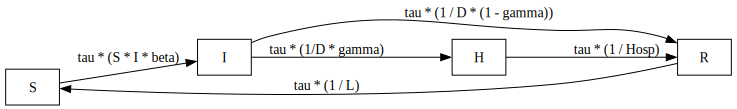

In [2]:
diagram_dot = """digraph {
    rankdir=LR;
    node [shape=box];
    S -> I [label="tau * (S * I * beta)"];
    I -> R [label="tau * (1 / D * (1 - gamma)) "];
    I -> H [label="tau * (1/D * gamma)"];
    H -> R [label="tau * (1 / Hosp)"];
    R -> S [label="tau * (1 / L)"]
}"""
diagram = pydot.graph_from_dot_data(diagram_dot)[0]  # type: ignore
SVG(data = diagram.create_svg())

# MCMC


In [3]:
def model(scale_x1,scale_x2, a): #par: a = [a0,a1,a2]

    test_beta = a[0]*np.exp(((a[1]*scale_x1)+(a[2]*scale_x2))) 
    return test_beta

In [4]:
def LogL(scale_x1,scale_x2, a, data):
    test_data = model(scale_x1,scale_x2, a)
    nd = norm(loc=test_data,scale = 0.0001)
    LogLval = nd.logpdf(data)
    return LogLval

In [282]:
scale_x1 = 7.977223978060467e-17
scale_x2 = -2.1652465083306982e-16
params_0 = [0.05,0.5,0.5] #initial guess
data = 0.3510816689301752 #beta

#first LL
LL_init = LogL(scale_x1,scale_x2, params_0, data)
param_set = []
param_set.append(params_0)

LL_set = []
LL_set.append(LL_init)

#tracks all param guesses--even if rejected
all_guesses = []
all_guesses.append(params_0)

iter_burn = 100_000
iter_count = 100_000
iter_total = iter_burn+iter_count

time_0 = time.process_time()
num_accept = 0
scale = np.array([0.1])

diff = 0.01

#MCMC
for i in range(1,iter_total):
    
    diffMatrix = np.diag(param_set[-1])
    paramtest = param_set[-1] + scale[0]*np.array([1,1,1])*np.random.multivariate_normal(mean=np.zeros((len(param_set[-1]),)), cov=diffMatrix)
    
    LL_test = LogL(scale_x1,scale_x2, paramtest, data)
    

    #perform MCMC--metropolis hastings

    accept = min(1,np.exp(LL_test - LL_set[-1]))

    if np.random.random() < accept:
        num_accept +=1
        LL_set.append(LL_test)
        param_set.append(paramtest)
    else:
        LL_set.append(LL_set[-1])
        param_set.append(param_set[-1])

    all_guesses.append(param_set[-1])

time_1 = time.process_time()

/var/folders/_v/4q2_l88n1vndy51_ksbfylnc0000gn/T/ipykernel_80741/2109258140.py:39: RuntimeWarning: overflow encountered in exp
  accept = min(1,np.exp(LL_test - LL_set[-1]))
/var/folders/_v/4q2_l88n1vndy51_ksbfylnc0000gn/T/ipykernel_80741/2109258140.py:32: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  paramtest = param_set[-1] + scale[0]*np.array([1,1,1])*np.random.multivariate_normal(mean=np.zeros((len(param_set[-1]),)), cov=diffMatrix)


In [35]:
param_set[-1]

array([3.50898134e-01, 9.06161442e+00, 3.69608426e-05])

In [49]:
# Infect 10,000 people in 10 randomly chosen locations.
RandomLocsInitializer(
    infection_seed_size= 200,
    infection_locations=10
)

# Infect 10,000 people in these 4 location by index.
IndexedLocsInitializer(
    infection_seed_size=10_000,
    infection_locations=[46, 104, 154, 2445]
)

# Infect 10,000 people in these 4 locations by label.
LabeledLocsInitializer(
    infection_seed_size=235,
    infection_locations=['040131058001', '040130101012', '040130101013	', '040130101021', '040130101022']
)

# Infect 10,000 people in the 10 locations with the least median age
BottomLocsInitializer(
    infection_seed_size=10_000,
    infection_locations=10,
    infection_attribute='median_age'
)

# Infect 10,000 people in the 10 locations with the highest population
TopLocsInitializer(
    infection_seed_size=1_000,
    infection_locations=10,
    infection_attribute='pop_density_km2'
)

In [52]:
seed_size = [25, 50, 75, 100, 125, 150, 175, 200, 225, 250]

sdh_builder = SdhBuilder()
sdh_builder.initializer = LabeledLocsInitializer(
    infection_seed_size= 225,
    infection_locations=['040131058001', '040130101012', '040130101013	', '040130101021', '040130101022']
)

sim = Simulation(
    geo=geo_library['maricopa_cbg_2019'](),
    ipm_builder=sdh_builder,
    mvm_builder=mm_library['centroids']()
)
 
phi = [10,20,30,40,50 ,60 ,70 ,80 ,90]

for i in range(len(phi)):
    out = sim.run( 
            param={
                'alpha': [param_set[-1][0],param_set[-1][1], param_set[-1][2]],
                'theta': 0.1,
                'gamma': 0.01000022,
                'phi': phi[i],
                'move_control': 0.9,
                'infection_duration': 6, # We may want to change this duration 
                'immunity_duration': 90.0,
                'hospitalization_duration': 5.3,
            },
            start_date=date(2019, 1, 1),
            duration_days=154,
            rng=np.random.default_rng(21)
        )
    phi_str = str(phi[i])
        # This is not very interesting output, but you get the idea.
    save_csv(f"{dir}/output_files/" + phi_str + "_sirh.csv", out)
    out.prevalence[0, 0:10]

In [184]:
exit_code = run(
    ipm_name = 'sdh',
    mm_name = 'centroids',
    geo_name = 'maricopa_cbg_2019',
    start_date_str = '2015-01-01',
    duration_str = '150d',
    params_path = f"{dir}/params/sdh_params.toml",
    out_path = f"{dir}/output_files/sirh.csv",
    chart = 'p0',
    profiling=False
)

Loading requirements:
[✓] IPM (sdh)
[✓] MM (centroids)
[✓] Geo (maricopa_cbg_2019)
[✓] Parameters (file:/Users/alexandernez/Desktop/Github/Epymorph/scratch/params/sdh_params.toml)

Running simulation:
• 2015-01-01 to 2015-05-31 (150 days)
• 2494 geo nodes


Exception: params missing infection_duration

# Arizona flu data


In [ ]:
Az_data

In [11]:
Az_data = pd.read_csv(dir + '/output_files/AZ_data.csv', low_memory=False)

flu = Az_data.filter(["hospital_pk",
                      "zip",
                      "hospital_name",
                      "fips_code",
                      "address",
                      "collection_week",
                      "total_patients_hospitalized_confirmed_influenza_7_day_avg",
                      "total_patients_hospitalized_confirmed_influenza_7_day_sum",
                      "total_patients_hospitalized_confirmed_influenza_7_day_coverage",
                      "previous_day_admission_influenza_confirmed_7_day_sum"])

flu['collection_week'] = pd.to_datetime(flu['collection_week'])

# Filter the dataset by years 
flu = flu[(flu['collection_week'] >= '2022-10-01') & (flu['collection_week'] <= '2023-12-31')]

# Filter data only within Maricopa county 
flu = flu[flu['fips_code'] == 4013.0]

# Filter and remove negative values for 'total_patients_hospitalized_confirmed_influenza_7_day_avg'
flu.drop(flu[flu['total_patients_hospitalized_confirmed_influenza_7_day_avg'] < 0].index, inplace=True)
flu.dropna(subset=['total_patients_hospitalized_confirmed_influenza_7_day_avg'], inplace=True)

# Filter and remove negative values for 'total_patients_hospitalized_confirmed_influenza_7_day_sum'
flu.drop(flu[flu['total_patients_hospitalized_confirmed_influenza_7_day_sum'] < 0].index, inplace=True)
flu.dropna(subset=['total_patients_hospitalized_confirmed_influenza_7_day_sum'], inplace=True)

# Filter and remove negative values for 'total_patients_hospitalized_confirmed_influenza_7_day_coverage'
flu.drop(flu[flu['total_patients_hospitalized_confirmed_influenza_7_day_coverage'] < 0].index, inplace=True)
flu.dropna(subset=['total_patients_hospitalized_confirmed_influenza_7_day_coverage'], inplace=True)

# Filter and remove negative values for 'previous_day_admission_influenza_confirmed_7_day_sum'
flu.drop(flu[flu['previous_day_admission_influenza_confirmed_7_day_sum'] < 0].index, inplace=True)
flu.dropna(subset=['previous_day_admission_influenza_confirmed_7_day_sum'], inplace=True)

# Group by 'collection_week' and sum the specified columns within each group
columns_to_sum = ["total_patients_hospitalized_confirmed_influenza_7_day_avg",
                  "total_patients_hospitalized_confirmed_influenza_7_day_sum",
                  "total_patients_hospitalized_confirmed_influenza_7_day_coverage",
                  "previous_day_admission_influenza_confirmed_7_day_sum"]

hospital_1 = flu[flu['hospital_name'] == 'BANNER - UNIVERSITY MEDICAL CENTER PHOENIX']
hospital_2 = flu[flu['hospital_name'] == 'VALLEYWISE HEALTH MEDICAL CENTER']
hospital_3 = flu[flu['hospital_name'] == 'ABRAZO ARROWHEAD CAMPUS']

hospital_1_grouped = hospital_1.groupby('collection_week')[columns_to_sum].sum().reset_index()
hospital_2_grouped = hospital_2.groupby('collection_week')[columns_to_sum].sum().reset_index()
hospital_3_grouped = hospital_3.groupby('collection_week')[columns_to_sum].sum().reset_index()
flu_grouped = flu.groupby('collection_week')[columns_to_sum].sum().reset_index()

In [ ]:
print(flu['hospital_name'].unique())

# Creates the Maricopa County dataframe

In [13]:
geo = 'https://www2.census.gov/geo/tiger/TIGER2020PL/STATE/04_ARIZONA/04013/tl_2020_04013_bg10.zip'
maricopa = gpd.read_file(geo)

In [17]:
num_labels = len(data['labels'])
distances = np.zeros((num_labels, num_labels))

def haversine(centroid_1_lon: float, centroid_1_lat: float,
              centroid_2_lon: float, centroid_2_lat: float) -> np.double:
    R = 3959.87433
    dLat = np.radians(centroid_1_lat - centroid_2_lat)
    dLon = np.radians(centroid_1_lon - centroid_2_lon)
    lat1 = np.radians(centroid_1_lat)
    lat2 = np.radians(centroid_2_lat)

    a = np.sin(dLat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dLon/2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    
    return R * c

# Calculate distances
for i in range(num_labels):
    for j in range(num_labels):
        if i != j:
            distances[i, j] = haversine(data['centroid'][i][0], data['centroid'][i][1],
                                       data['centroid'][j][0], data['centroid'][j][1])

np.savetxt(f"{dir}/utility/dist.csv", distances, delimiter=",")

# Calculate phi values
phi_70 = 1 / np.exp(distances * (1/70))
phi_40 = 1 / np.exp(distances * (1/40))
phi_10 = 1 / np.exp(distances * (1/10))

# Save phi and distances as CSV
phi_70_df = pd.DataFrame(phi_70)
phi_40_df = pd.DataFrame(phi_40)
phi_10_df = pd.DataFrame(phi_10)
dist_df = pd.DataFrame(distances)

phi_70_df.to_csv(f"{dir}/utility/phi_70.csv", index=False)
phi_40_df.to_csv(f"{dir}/utility/phi_40.csv", index=False)
phi_10_df.to_csv(f"{dir}/utility/phi_10.csv", index=False)
dist_df.to_csv(f"{dir}/utility/dist.csv", index=False)

# Combine data into a single DataFrame
cgb_d = dist_df.iloc[:, 0]
cgb_70 = phi_70_df.iloc[:, 0]
cgb_40 = phi_40_df.iloc[:, 0]
cgb_10 = phi_10_df.iloc[:, 0]

cgb = pd.concat([cgb_d, cgb_70, cgb_40, cgb_10], axis=1)
cgb.columns = ["distance", "phi 70", "phi 40", "phi 10"]
cgb = cgb.sort_values(by='distance')


In [187]:
# Step 1: Define the B-spline basis functions beta_n(x) and phi_m(y)
# Define your basis functions here...
# Step 2: Define the B-spline function f(x, y)

def bspline(x, y, params):

    a, b, c = params[:3]

    alpha_n = params[3:11]

    gamma_m = params[11:]

    beta_sum = np.sum([alpha * beta_n(x) for alpha, beta_n in zip(alpha_n, beta_functions)])

    phi_sum = np.sum([gamma * phi_m(y) for gamma, phi_m in zip(gamma_m, phi_functions)])

    return a * (np.exp(b * beta_sum) + np.exp(c * phi_sum))

# Step 3: Collect your data (x_i, y_i, z_i)

# Step 4: Minimize the error

def error_function(params):
    error = 0
    for x_i, y_i, z_i in zip(x_data, y_data, z_data):

        error += (bspline(x_i, y_i, params) - z_i) ** 2
    return error
 
# Initial guess for the parameters (a, b, c, alpha_n, gamma_m)
initial_params = np.ones(19)  # Change the size based on the number of parameters you have

# Perform the optimization
result = minimize(error_function, initial_params)

# Get the optimized parameters

optimized_params = result.x

# Step 5: Evaluate the fitted B-spline function at any point (x, y)
x_test = 2.0  # Change this to any test value of x
y_test = 3.0  # Change this to any test value of y
fitted_value = bspline(x_test, y_test, optimized_params)

print("Fitted value at ({}, {}): {}".format(x_test, y_test, fitted_value))

NameError: name 'x_data' is not defined

# Creates the Social Determinate of Health dataframe

In [284]:
sdh_df['gamma'] = 0 
sdh_df['gamma 0'] = 0.01000022

sdh_df['count'] = 1

sdh_df['x1'] = 0
sdh_df['x2'] = 0
sdh_df["h1"] = 0
sdh_df["h2"] = 0

sdh_df['beta'] = 0
sdh_df['alpha 0'] = param_set[-1][0]
sdh_df["alpha 1"] =  param_set[-1][1]
sdh_df["alpha 2"] =  param_set[-1][2]

for i in range(len(sdh_df)):
    
    # Alpha values used to control beta
    a0 = sdh_df['alpha 0'][i]
    a1 = sdh_df['alpha 1'][i]
    a2 = sdh_df['alpha 2'][i]

    # Social Determinate of Health (SDH) values for beta
    x1 = sdh_df["average_household_size"][i]
    x2 = sdh_df["pop_density_km2"][i]
    
    # Social Determinate of Health (SDH) values for gamma
    h1 = sdh_df["median_income"][i]
    h2 = sdh_df["tract_gini_index"][i]

    # Scaling function used to calculate beta and gamma 
    scale_x1 = (x1 - sdh_df["average_household_size"].mean()) / sdh_df["average_household_size"].std()
    scale_x2 = (x2 - sdh_df["pop_density_km2"].mean()) / sdh_df["pop_density_km2"].std()
    scale_h1 = (h1 - sdh_df["median_income"].mean()) / sdh_df["median_income"].std()
    scale_h2 = (h2 - sdh_df["tract_gini_index"].mean()) / sdh_df["tract_gini_index"].std()

    # Calculate gamma based on Alpha values used to control gamma
    g0 = sdh_df["gamma 0"][i]
  
    # Calculate the value of beta and gramma for each nodes
    beta = a0 * np.exp((( a1 * scale_x2) + (a2 * scale_x1)))
    gamma = g0 * (np.exp(-(scale_h1 + scale_h2)) / (1 + np.exp(-(scale_h1 + scale_h2))))

    # Saved the calculate value of beta and gamma in its respected node index
    sdh_df.loc[i, ['beta', 'gamma', 'x1', 'x2', 'h1', 'h2']] = [beta, gamma, scale_x1, scale_x2, scale_h1, scale_h2]

In [279]:
pei = pd.read_csv(dir + '/Utility/pei_humidity.csv')

# Define the transformation function
def calculate_beta(x):
    r0_min = 1.3
    r0_max = 2.0
    a = -180.0
    b = np.log(r0_max - r0_min)
    return (np.exp(a * x + b) + r0_min) / 4

# Apply the transformation to each state column
states = ['FL', 'GA', 'MD', 'NC', 'SC', 'VA']
for state in states:
    pei[state + '_beta'] = calculate_beta(pei[state])

# Reorder columns and drop the original state columns
pei = pei[[state + '_beta' for state in states]]

# Creates the IPM dataframe

In [65]:
header_names = ['ticks', 'tracts', 'S', 'I', 'R', 'H', 'S->I', 'I->R', 'I->H','H->R', 'R->S']

max_df = pd.read_csv(dir + '/output_files/90_sirh.csv', header= None, skiprows = 1, names = header_names)
max_df['I & H->R'] = max_df['I->R'] + max_df['H->R']
max_df['count'] = 1

df = pd.read_csv(dir + '/output_files/90_sirh.csv', header= None, skiprows = 1, names = header_names)
df['I & H->R'] = df['I->R'] + df['H->R']
sdh_df['count'] = 1

plot_df = pd.read_csv(dir + '/output_files/90_sirh.csv', header= None, skiprows = 1, names = header_names)
plot_df['I & H->R'] = plot_df['I->R'] + plot_df['H->R']

df = df.groupby(['tracts'], as_index=False).sum().drop(labels = 'ticks', axis = 'columns').sort_index()
plot_df = plot_df.groupby(['ticks'], as_index=False).sum().drop(labels = 'tracts', axis = 'columns').sort_index()

In [152]:
beta_.head()

,index,labels,population,centroid,median_age,pop_by_age,median_income,total_income,average_household_size,pop_density_km2,...,gamma 0,count,x1,x2,h1,h2,beta,alpha 0,alpha 1,alpha 2
0,0,040130101011,1791,"[-111.770772219983, 33.7692433720249]",50.5,"[358, 110, 671, 374, 194, 84]",99219,90125800,2.33,99.301764,...,0.01,1,-0.596410,-1.219544,0.795415,0.594326,0.321368,0.35,0.04125,0.05875
1,1,040130101012,2007,"[-111.720000642927, 33.741096326025]",63.9,"[162, 0, 423, 460, 559, 403]",127614,155213500,2.15,68.730308,...,0.01,1,-0.832030,-1.237052,1.586004,0.594326,0.316722,0.35,0.04125,0.05875
2,2,040130101013,1264,"[-111.666997365524, 33.7239868229889]",70.8,"[0, 22, 0, 249, 655, 338]",80742,73694600,1.83,183.139061,...,0.01,1,-1.250911,-1.171532,0.280968,0.594326,0.309859,0.35,0.04125,0.05875
3,3,040130101021,1139,"[-111.490977560506, 33.715337047738]",58.9,"[58, 52, 361, 362, 258, 48]",105987,89511200,2.04,0.474269,...,0.01,1,-0.976020,-1.276141,0.983853,2.241901,0.313548,0.35,0.04125,0.05875
4,4,040130101022,1487,"[-111.850574119318, 33.8260427149521]",62.8,"[110, 82, 202, 500, 452, 141]",128523,128439900,2.20,125.178297,...,0.01,1,-0.766580,-1.204725,1.611313,2.241901,0.318366,0.35,0.04125,0.05875


In [148]:
beta_ = sdh_df.reset_index()
#test = test.dropna(subset=['beta'], inplace=True)
beta_.dropna(subset=['beta'], inplace=True)

beta_df_values = [df, beta_]
beta_df = pd.concat(beta_df_values, axis =1)

In [149]:
beta_df.head()

,tracts,S,I,R,H,S->I,I->R,I->H,H->R,R->S,...,gamma 0,count,x1,x2,h1,h2,beta,alpha 0,alpha 1,alpha 2
0,0,551628,0,0,0,0,0,0,0,0,...,0.01,1,-0.596410,-1.219544,0.795415,0.594326,0.321368,0.35,0.04125,0.05875
1,1,467976,13699,136442,39,1077,1128,7,7,760,...,0.01,1,-0.832030,-1.237052,1.586004,0.594326,0.316722,0.35,0.04125,0.05875
2,2,389312,0,0,0,0,0,0,0,0,...,0.01,1,-1.250911,-1.171532,0.280968,0.594326,0.309859,0.35,0.04125,0.05875
3,3,316098,2393,32280,41,200,234,2,2,165,...,0.01,1,-0.976020,-1.276141,0.983853,2.241901,0.313548,0.35,0.04125,0.05875
4,4,345127,11356,101417,96,891,915,10,10,592,...,0.01,1,-0.766580,-1.204725,1.611313,2.241901,0.318366,0.35,0.04125,0.05875


# Combines all the dataframe to create a geopandas dataframe

In [133]:
data = [df, sdh_df, lat_lon_df, maricopa]
geo_df = pd.concat(data, axis =1)
gpd_df = gpd.GeoDataFrame(geo_df)

gpd_df.to_csv(dir + '/utility/gpd.csv')

# Plotting result

## IPM graphs


In [57]:
header_names = ['ticks', 'tracts', 'S', 'I', 'R', 'H', 'S->I', 'I->R', 'I->H','H->R', 'R->S']

seed_1 = pd.read_csv(dir + '/output_files/sirh.csv', header= None, skiprows = 1, names = header_names)
seed_2 = pd.read_csv(dir + '/output_files/sirh.csv', header= None, skiprows = 1, names = header_names)
seed_3 = pd.read_csv(dir + '/output_files/sirh.csv', header= None, skiprows = 1, names = header_names)
seed_4 = pd.read_csv(dir + '/output_files/sirh.csv', header= None, skiprows = 1, names = header_names)

seed_1['I & H->R'] = seed_1['I->R'] + seed_1['H->R']
seed_2['I & H->R'] = seed_2['I->R'] + seed_2['H->R']
seed_3['I & H->R'] = seed_3['I->R'] + seed_3['H->R']
seed_4['I & H->R'] = seed_4['I->R'] + seed_4['H->R']

events_1 = seed_1[['ticks','R->S', 'S->I', 'I & H->R', 'I->H']]
events_1 = events_1.groupby(events_1['ticks'] // 14, as_index=False).sum()

events_2 = seed_2[['ticks','R->S', 'S->I', 'I & H->R', 'I->H']]
events_2 = events_2.groupby(events_2['ticks'] // 14, as_index=False).sum()

events_3 = seed_3[['ticks','R->S', 'S->I', 'I & H->R', 'I->H']]
events_3 = events_3.groupby(events_3['ticks'] // 14, as_index=False).sum()

events_4 = seed_4[['ticks','R->S', 'S->I', 'I & H->R', 'I->H']]
events_4 = events_4.groupby(events_4['ticks'] // 14, as_index=False).sum()

compartment_1 = seed_1[['ticks', 'S', 'I', 'R', 'H']]
compartment_1 = compartment_1.groupby(compartment_1['ticks'] // 2, as_index=False).sum()

compartment_2 = seed_2[['ticks', 'S', 'I', 'R', 'H']]
compartment_2 = compartment_2.groupby(compartment_2['ticks'] // 2, as_index=False).sum()

compartment_3 = seed_3[['ticks', 'S', 'I', 'R', 'H']]
compartment_3 = compartment_3.groupby(compartment_3['ticks'] // 2, as_index=False).sum()

compartment_4 = seed_4[['ticks', 'S', 'I', 'R', 'H']]
compartment_4 = compartment_4.groupby(compartment_4['ticks'] // 2, as_index=False).sum()



In [160]:
Events

,ticks,S->I,I->R,I->H,H->R,R->S,I & H->R
0,1,49,32,0,0,0,32
1,5,48,38,1,0,0,38
2,9,51,49,1,0,1,49
3,13,63,49,0,0,1,49
4,17,64,46,0,0,0,46
...,...,...,...,...,...,...,...
149,597,12,11,0,0,13,11
150,601,5,8,0,0,10,8
151,605,9,11,0,0,17,11
152,609,9,8,0,0,11,8


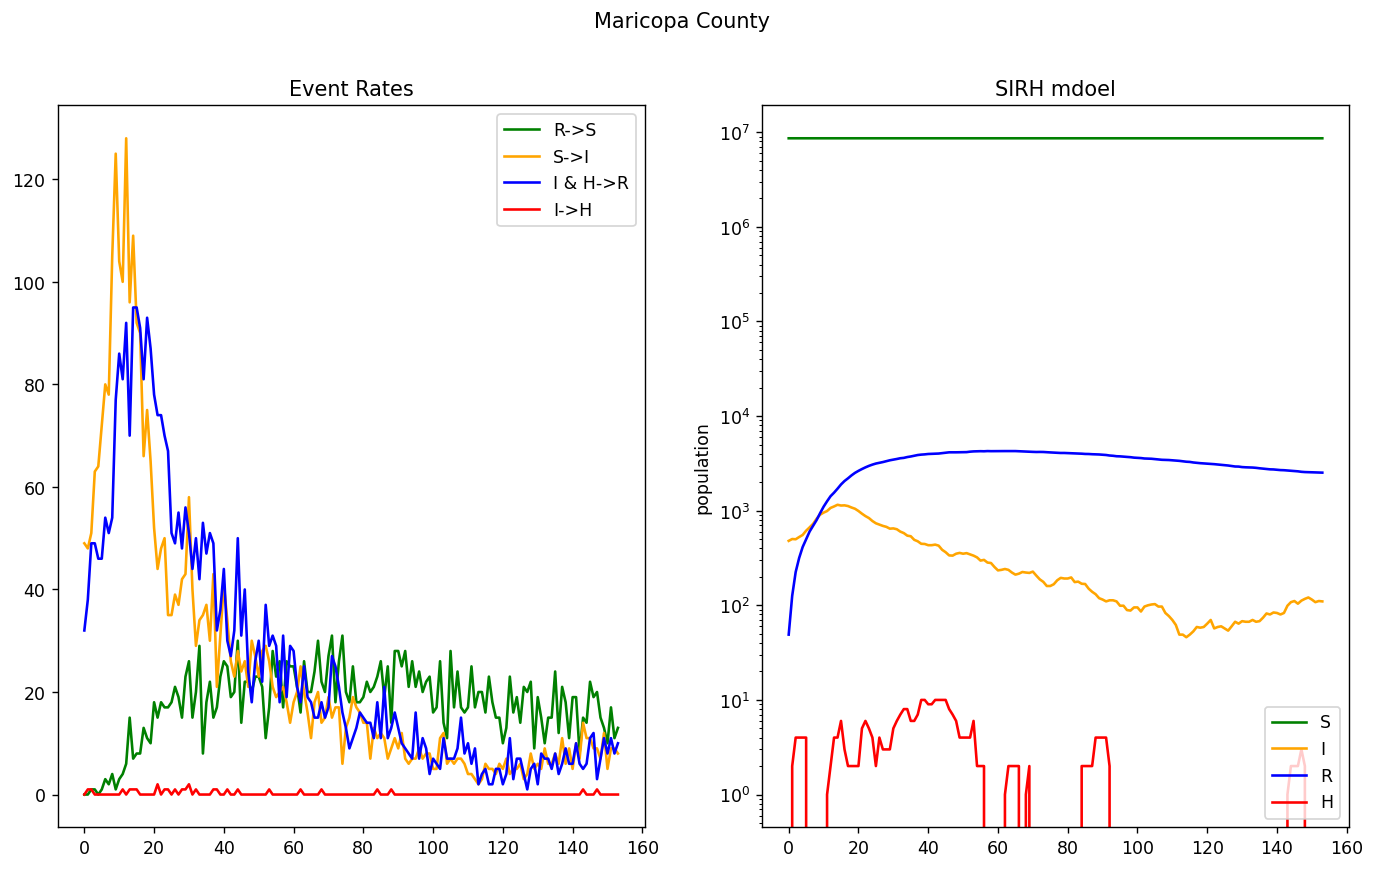

In [159]:
# Get current axis
plot_df.groupby(['ticks']).sum()
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize=(13.33,7.5), dpi=125)

fig.suptitle('Maricopa County')
sirh = ['S', 'I', 'R', 'H']
sirh_name = ['Susceptible', 'Infected', 'Recovered', 'hospitalized']
event_rate = ['R->S', 'S->I', 'I & H->R', 'I->H' ]
color = ['green', 'orange', 'blue', 'red']

Events = plot_df[['ticks', 'S->I', 'I->R', 'I->H','H->R', 'R->S', 'I & H->R']]
sirh_compartment = plot_df[['ticks', 'S', 'I', 'R', 'H']]
sirh_compartment = sirh_compartment.groupby(sirh_compartment['ticks'] // 2, as_index=False).sum()
Events = Events.groupby(Events['ticks'] // 2, as_index=False).sum()

# Plots sirh model
for i in range(4):
    sirh_compartment.plot(kind='line',
            y= sirh[i],
            ylabel="population", 
            logy=True,
            color=color[i], 
            ax=axes[1],
            title = 'SIRH mdoel') 
    Events.plot(kind='line', 
            y=event_rate[i],
            color=color[i], 
            ax=axes[0],
            title = 'Event Rates')    
# show the plot
plt.savefig(dir+'/plots/sirh/SIRH_model.png', bbox_inches='tight')
plt.show()

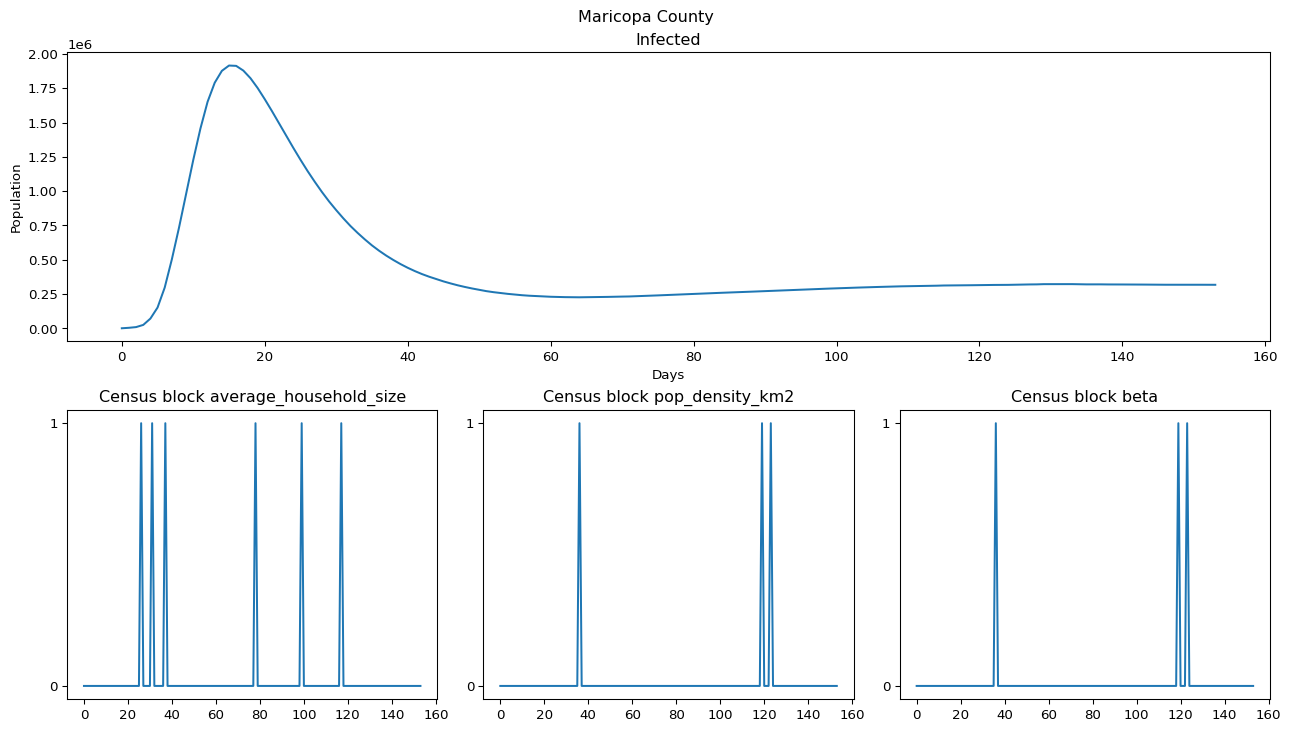

In [23]:
max_beta = ['average_household_size', 'pop_density_km2', 'beta']

fig = plt.figure(figsize=(13.33, 7.5), dpi=96, constrained_layout=True)
fig.suptitle('Maricopa County')

spec = fig.add_gridspec(2, 3)
ax0 = fig.add_subplot(spec[0, :])
ax0.plot(sirh_compartment['I'])
ax0.set_ylabel('Population')
ax0.set_xlabel('Days')
ax0.set_title('Infected')

# Create subplots for census blocks
ax10 = fig.add_subplot(spec[1, 0])
ax11 = fig.add_subplot(spec[1, 1])
ax12 = fig.add_subplot(spec[1, 2])

# Iterate over census blocks
for i, ax in enumerate([ax10, ax11, ax12]):
    selected_id = geo_df[max_beta[i]].idxmin()  # Manually choose the ID number you want to access

    # Filter the DataFrame to include only rows with the selected tract number
    selected_rows = max_df.loc[max_df['tracts'] == selected_id]

    # Get current axis
    Events_t = selected_rows[['ticks', 'S->I', 'I->R', 'I->H', 'H->R', 'R->S', 'I & H->R']]
    compartment = selected_rows[['ticks', 'S', 'I', 'R', 'H']]
    compartment = compartment.groupby(compartment['ticks'] // 2, as_index=False).sum()
    Events_t = Events_t.groupby(Events_t['ticks'] // 2, as_index=False).sum()

    ax.plot(compartment['H'])
    ax.set_title(f'Census block {max_beta[i]}')

    # Set y-axis ticks to whole numbers
    ax.yaxis.set_major_locator(ticker.MaxNLocator(integer=True))

plt.savefig(dir + '/plots/powerpoint/Maricopa_infected_cgb.png', dpi=300, bbox_inches='tight')
plt.show()

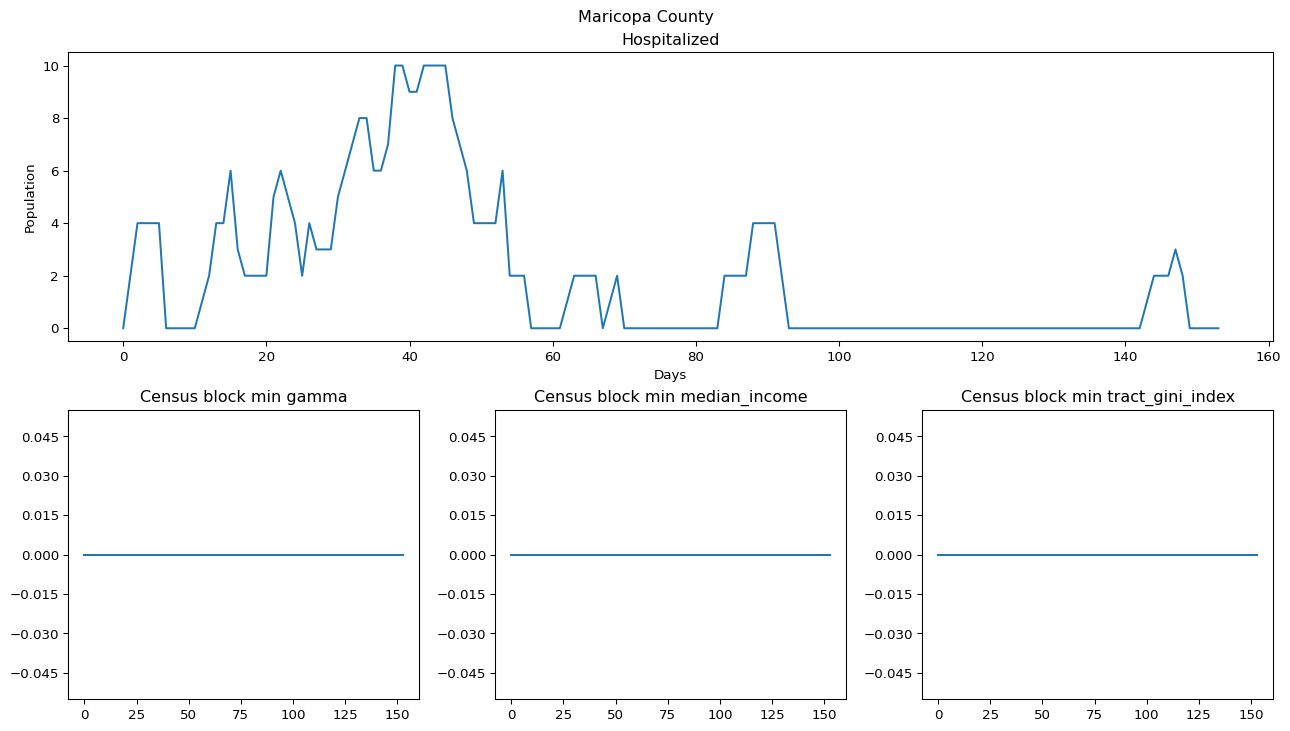

In [294]:
max_gamma = ['gamma', 'median_income', 'tract_gini_index']

fig = plt.figure(figsize=(13.33, 7.5), dpi=96, constrained_layout=True)
fig.suptitle('Maricopa County')

spec = fig.add_gridspec(2, 3)
ax0 = fig.add_subplot(spec[0, :])
ax0.plot(sirh_compartment['H'])
ax0.set_ylabel('Population')
ax0.set_xlabel('Days')
ax0.set_title('Hospitalized')

# Create subplots for census blocks
ax10 = fig.add_subplot(spec[1, 0])
ax11 = fig.add_subplot(spec[1, 1])
ax12 = fig.add_subplot(spec[1, 2])

# Iterate over census blocks
for i, ax in enumerate([ax10, ax11, ax12]):
    selected_id = sdh_df[max_gamma[i]].idxmax()  # Manually choose the ID number you want to access

    # Filter the DataFrame to include only rows with the selected tract number
    selected_rows = max_df.loc[max_df['tracts'] == selected_id]

    # Get current axis
    Events_t = selected_rows[['ticks', 'S->I', 'I->R', 'I->H', 'H->R', 'R->S', 'I & H->R']]
    compartment = selected_rows[['ticks', 'S', 'I', 'R', 'H']]
    compartment = compartment.groupby(compartment['ticks'] // 2, as_index=False).sum()
    Events_t = Events_t.groupby(Events_t['ticks'] // 2, as_index=False).sum()

    ax.plot(compartment['H'])
    ax.set_title(f'Census block min {max_gamma[i]}')

    # Set y-axis ticks to whole numbers
    ax.yaxis.set_major_locator(ticker.MaxNLocator(integer=True))

plt.savefig(dir + '/plots/powerpoint/Maricopa_hospitalized_cgb.png', dpi=300, bbox_inches='tight')

plt.show()

In [293]:
30/100_000

0.0003

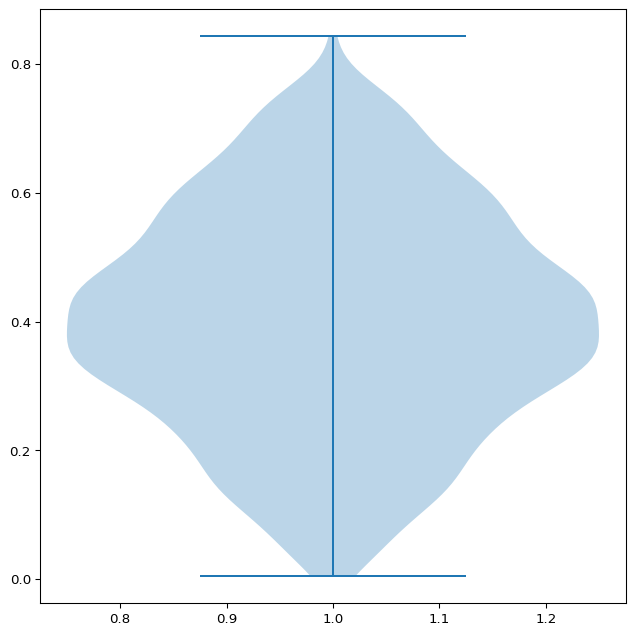

In [292]:
fig = plt.figure(figsize=(6.5,6.5), dpi=96, layout="constrained")
plt.violinplot(sdh_df['beta'])
plt.show()

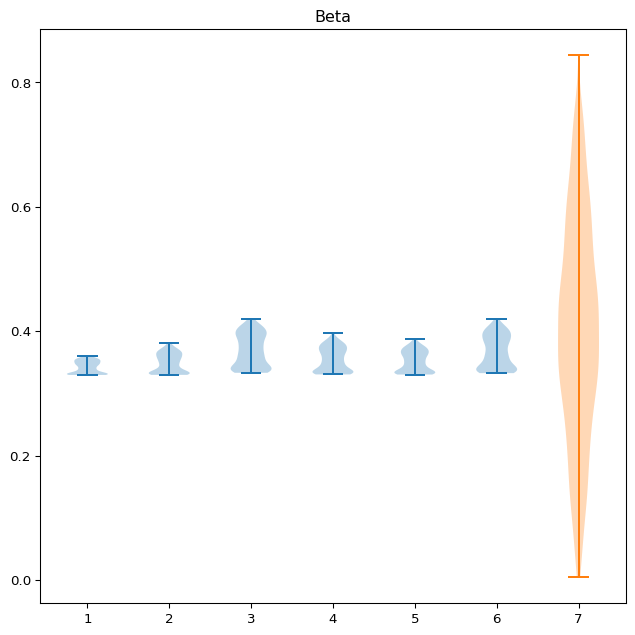

In [285]:
fig = plt.figure(figsize=(6.5,6.5), dpi=96, layout="constrained")
labels = ['FL beta', 'GA beta', 'MD beta','NC beta', 'SC beta', 'VA beta', 'Sim beta' ]
plt.title('Beta')

plt.violinplot(pei)
plt.violinplot(sdh_df['beta'], positions=[7])

plt.savefig(dir + '/plots/powerpoint/beta.png', dpi=300, bbox_inches='tight')           

plt.show()

In [ ]:
fig = plt.figure(figsize=(13.33,7.5), dpi=125, constrained_layout=True)
fig.suptitle('Maricopa County')

# First subplot
ax1 = fig.add_subplot(2, 2, 1)
ax1.plot(compartment_1['S'])
ax1.set_ylabel('Population')
ax1.set_xlabel('Days')
ax1.set_title('Susceptile')

# Second subplot
ax2 = fig.add_subplot(2, 2, 2)
ax2.plot(compartment_2['I'])
ax2.set_ylabel('Population')
ax2.set_xlabel('Days')
ax2.set_title('Infected')

# Third subplot
ax3 = fig.add_subplot(2, 2, 3)
ax3.plot(compartment_3['R'])
ax3.set_ylabel('Population')
ax3.set_xlabel('Days')
ax3.set_title('Recovered')

# Fourth subplot
ax4 = fig.add_subplot(2, 2, 4)
ax4.plot(compartment_4['H'])
ax4.set_ylabel('Population')
ax4.set_xlabel('Days')
ax4.set_title('Hospitalized')

plt.show()

## Movement models

In [ ]:
fig = plt.figure(figsize=(13.33,7.5), dpi=125)

fig.suptitle('Centroid Movement Model')
cgb.plot(x='distance',
        ylabel = 'Probability of movement', 
        xlabel = "Distance between census block groups (mi)",
        title = 'Centroid Movement Model')
plt.savefig(dir+'/plots/Movement_model/Centroid_movement.png', bbox_inches='tight')
plt.close()

In [ ]:
# Load the pairwise distance matrix from the CSV file
dist = pd.read_csv(dir + '/Utility/phi_40.csv', index_col=0)
dist = pd.read_csv(dir + '/Utility/phi_10.csv', index_col=0)

subset = dist.iloc[0:30, 0:30]  # Extract the first 25 rows and 25 columns

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(20, 8), dpi=125)

# Plot the heatmap on the first subplot
sns.heatmap(
    subset,
    cmap='OrRd',
    linewidth=0.01,
    ax=ax1
)
ax1.set_ylabel('Census Block Groups')
ax1.set_xlabel('Census Block Groups')
ax1.set_title('Centroids Movement Model')

# Plot the line plot on the second subplot
cgb.plot(x='distance',
         y='phi 40',
         ax=ax2)
ax2.set_ylabel('Probability of movement')
ax2.set_xlabel('Distance between census block groups (mi)')
ax2.set_title('Centroid Movement Model')

# Remove x and y ticks from the heatmap plot
ax1.set_xticks([])
ax1.set_yticks([])

plt.tight_layout()  # Adjust subplot spacing
filename = 'movement_figure.png'
plt.savefig(dir + '/' + filename,bbox_inches='tight')

plt.savefig(dir + '/plots/Movement_model/centriod_and_phi.png', dpi=300, bbox_inches='tight')
plt.close()

In [ ]:
# Load the pairwise distance matrix from the CSV file
dist_phi_40 = pd.read_csv(dir + '/Utility/phi_40.csv', index_col=0)
dist_phi_10 = pd.read_csv(dir + '/Utility/phi_10.csv', index_col=0)

subset_phi_40 = dist_phi_40.iloc[31:60, 31:60]  # Extract the first 25 rows and 25 columns
subset_phi_10 = dist_phi_10.iloc[31:60, 31:60]  # Extract the first 25 rows and 25 columns

# Create the figure and axes
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 8), dpi=125)

# Plot the first heatmap on the top left subplot
sns.heatmap(
    subset_phi_40,
    cmap='OrRd',
    linewidth=0.01,
    ax=axs[0, 0]
)
axs[0, 0].set_ylabel('Census Block Group')
axs[0, 0].set_xlabel('Census Block Group')
axs[0, 0].set_aspect('equal')

# Plot the second heatmap on the bottom left subplot
sns.heatmap(
    subset_phi_10,
    cmap='OrRd',
    linewidth=0.01,
    ax=axs[1, 0]
)
axs[1, 0].set_ylabel('Census Block Group')
axs[1, 0].set_xlabel('Census Block Group')
axs[1, 0].set_aspect('equal')

# Plot the first line plot on the top right subplot
cgb.plot(x='distance',
         y='phi 40',
         ax=axs[0, 1])
axs[0, 1].set_ylabel('Probability of Movement')

# Plot the second line plot on the bottom right subplot
cgb.plot(x='distance',
         y='phi 10',
         ax=axs[1, 1])
axs[1, 1].set_ylabel('Probability of Movement')

# Remove x and y ticks from the heatmaps plots
axs[0, 0].set_xticks([])
axs[0, 0].set_yticks([])
axs[1, 0].set_xticks([])
axs[1, 0].set_yticks([])

# Set a common title for the top row
fig.suptitle('Phi 40', fontsize=14, fontweight='bold')

# Set a common title for the bottom row
fig.text(0.5, 0.475, 'Phi 10', ha='center', fontsize=14, fontweight='bold')

# Adjust subplot spacing and margins
plt.tight_layout()  # Adjust subplot spacing

plt.savefig(dir + '/plots/Movement_model/centriod_and_phi.png', dpi=300, bbox_inches='tight')

plt.close()

In [ ]:
# Load the pairwise distance matrix from the CSV file
phi_10 = pd.read_csv(dir + '/Utility/phi_10.csv', index_col=0)
phi_40 = pd.read_csv(dir + '/Utility/phi_40.csv', index_col=0)
phi_70 = pd.read_csv(dir + '/Utility/phi_70.csv', index_col=0)

phi_10_subset = phi_10.iloc[0:29, 0:29]  # Extract the first 30 rows and 30 columns
phi_40_subset = phi_40.iloc[0:29, 0:29]  # Extract the first 30 rows and 30 columns
phi_70_subset = phi_70.iloc[0:29, 0:29]  # Extract the first 30 rows and 30 columns

phi_subset = [phi_10_subset, phi_40_subset, phi_70_subset]
phi_df = pd.concat(phi_subset, axis =0).T 

plt.figure(figsize=(24, 8), dpi=125)

# Plot the heatmap on the first subplot
sns.heatmap(
    phi_df,
    cmap='OrRd',
    linewidth=0.01,
)
plt.ylabel('Census Blcok Groups')
plt.xlabel('')

plt.tick_params(left = False, right = False , labelleft = False ,
                labelbottom = False, bottom = False)

plt.savefig(dir + '/plots/Movement_model/phi_figure.png', bbox_inches='tight')           
# Show the plot
plt.close()

## Spatial Distribution 

In [ ]:
fnx = ['beta', 'gamma']
scaled_sdh = ['x1','x2','h1','h2']
sdh = ['median_income', 'pop_density_km2', 
        'tract_gini_index', 'average_household_size']
sirh = ['S', 'I', 'R', 'H',]

maps = [*fnx, *scaled_sdh, *sdh, *sirh]
folder = ['fnx/', 'scaled_sdh/', 'sdh/', 'SIRH/']
maps = [*fnx, *scaled_sdh, *sdh, *sirh]

In [ ]:
fig, ax = plt.subplots(figsize=(13.33,7.5), dpi=96)

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)

maricopa.plot(ax = ax, edgecolor='black',color='grey', linewidth = 0.1)

for i in range(len(maps)):
    gpd_df.plot(
        ax = ax, 
        edgecolor = 'black', 
        column = maps[i], 
        legend = True, 
        cmap='Blues',
        vmin = geo_df[maps[i]].min(), 
        vmax = geo_df[maps[i]].max(),
        linewidth = 0.01,
        cax=cax,
        legend_kwds={"label": maps[i], "orientation": "vertical"},
        )
    png = str(maps[i])
    sim_maps = str(maps[i])

    if png in fnx:
        path = str(folder[0])
    elif png in str(scaled_sdh):
        path = folder[1]
    elif png in sdh:
        path = str(folder[2])
    else:
        path = str(folder[3])
    
    plt.savefig(dir+ '/plots/' + path + '.png', bbox_inches='tight')
    plt.close()

In [ ]:
fig, ax = plt.subplots(figsize=(13.33,7.5), dpi=96)
minx, miny, maxx, maxy = [-112.5, 33.8, -111.8, 33.2]

ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)

maricopa.plot(ax = ax, edgecolor='black',color='grey', linewidth = 0.1)

for i in range(len(maps)):
    gpd_df.plot(
        ax = ax, 
        edgecolor = 'black', 
        column = maps[i], 
        legend = True, 
        cmap='Blues',
        vmin = geo_df[maps[i]].min(), 
        vmax = geo_df[maps[i]].max(),
        linewidth = 0.01,
        cax=cax,
        legend_kwds={"label": maps[i], "orientation": "vertical"},
        )
    png = str(maps[i])
    sim_maps = str(maps[i])

    if png in fnx:
        path = str(folder[0])
    elif png in str(scaled_sdh):
        path = folder[1]
    elif png in sdh:
        path = str(folder[2])
    else:
        path = str(folder[3])
    

    plt.savefig(dir+ '/plots/zoom/' + path + '/' + sim_maps + '.png', bbox_inches='tight')
    plt.close()

In [ ]:
# Define the titles for the maps
title1 = "Spatial Distribution of Hospitalized in Maricopa"
title2 = "Spatial Distribution of Hospitalization Rate in Maricopa"

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10), dpi=96)
minx, miny, maxx, maxy = [-112.5, 33.8, -111.8, 33.2]

# Set limits for both axes
ax1.set_xlim(minx, maxx)
ax1.set_ylim(miny, maxy)
ax2.set_xlim(minx, maxx)
ax2.set_ylim(miny, maxy)

# Create colorbar axes
divider1 = make_axes_locatable(ax1)
cax1 = divider1.append_axes("right", size="5%", pad=0.1)
divider2 = make_axes_locatable(ax2)
cax2 = divider2.append_axes("right", size="5%", pad=0.1)

maricopa.plot(ax=ax1, edgecolor='black', color='grey', linewidth=0.01)


# Plot first map on ax1
gpd_df.plot(ax=ax1, edgecolor='black', column='H', legend=True, cmap='Reds',
                vmin=geo_df['H'].min(), vmax=geo_df['H'].max(), linewidth=0.001,
                cax=cax1, legend_kwds={"label": 'Hospitalized', "orientation": "vertical"})

ax1.set_title(title1)  # Set the title for the first map

# Plot second map on ax2
maricopa.plot(ax=ax2, edgecolor='black', color='grey', linewidth=0.01)
gpd_df.plot(ax=ax2, edgecolor='black', column='gamma', legend=True, cmap='Reds',
                vmin=geo_df['gamma'].min(), vmax=geo_df['gamma'].max(), linewidth=0.001,
                cax=cax2, legend_kwds={"label": 'Hospitalization Rate', "orientation": "vertical"})

ax2.set_title(title2)  # Set the title for the second map

plt.savefig(dir + '/plots/powerpoint/Spatial_distribution_for_H.png', dpi=300, bbox_inches='tight')
plt.close()

In [ ]:
# Create a single subplot

fig, ax = plt.subplots(figsize=(10, 10), dpi=96)

# Set limits for the axes
minx, miny, maxx, maxy = [-112.5, 33.8, -111.8, 33.2]
ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)

# Create colorbar axes
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)

# Plot the map on the single axes
maricopa.plot(ax=ax, edgecolor='black', color='grey', linewidth=0.01)
gpd_df.plot(ax=ax, edgecolor='black', column='beta', legend=True, cmap='viridis',
            vmin=geo_df['beta'].min(), vmax=geo_df['beta'].max(), linewidth=0.001,
            cax=cax, legend_kwds={"label": 'Infected', "orientation": "vertical"})

ax.set_title(title1)  # Set the title for the map

plt.savefig(dir + '/plots/powerpoint/zoom_spatial_distribution.png', dpi=300, bbox_inches='tight')

plt.close()

In [ ]:
# Create the figure and axes
fig, ax = plt.subplots(figsize=(10, 10))

# Set up the divider for the colorbar
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)

# Plot the map
maricopa.plot(
    ax=ax,
    edgecolor='black',
    color='grey',
    linewidth=0.1
)

gpd_df.plot(
    ax=ax,
    edgecolor='black',
    column='beta',
    legend=True,
    cmap='viridis',  # Red color scale
    vmin=geo_df['beta'].min(),
    vmax=geo_df['beta'].max(),
    linewidth=0.005,
    cax=cax,
    legend_kwds={"label": 'Infected', "orientation": "vertical"},
)

# Set the title
ax.set_title('Infection Levels')

# Saves map
plt.savefig(dir + '/plots/powerpoint/spatial_distribution.png', dpi=300, bbox_inches='tight')

# Show the plot
plt.close()

In [ ]:
# Create the figure and axes
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))

# Set up the divider for the colorbars
divider1 = make_axes_locatable(ax1)
cax1 = divider1.append_axes("right", size="5%", pad=0.1)

divider2 = make_axes_locatable(ax2)
cax2 = divider2.append_axes("right", size="5%", pad=0.1)

# Plot the first map on ax1
maricopa.plot(
    ax=ax1,
    edgecolor='black',
    color='grey',
    linewidth=0.01
)

gpd_df.plot(
    ax=ax1,
    edgecolor='black',
    column='I',
    legend=True,
    cmap='Blues',
    vmin=geo_df['I'].min(),
    vmax=geo_df['I'].max(),
    linewidth=0.01,
    cax=cax1,
    legend_kwds={"label": 'Infected', "orientation": "vertical"},
)

# Plot the second map on ax2
maricopa.plot(
    ax=ax2,
    edgecolor='black',
    color='grey',
    linewidth=0.01
)

gpd_df.plot(
    ax=ax2,
    edgecolor='black',
    column='I',
    legend=True,
    cmap='viridis',
    vmin=geo_df['I'].min(),
    vmax=geo_df['I'].max(),
    linewidth=0.01,
    cax=cax2,
    legend_kwds={"label": 'Transmission Rate', "orientation": "vertical"},
)

# Set the title for each subplot
ax1.set_title('Infection Levels')
ax2.set_title('Transmission Rate')

# Set the limits for the x and y axes to zoom in further (same for both maps)
center_x = (maricopa.total_bounds[0] + maricopa.total_bounds[2]) / 2
center_y = (maricopa.total_bounds[1] + maricopa.total_bounds[3]) / 2
width = maricopa.total_bounds[2] - maricopa.total_bounds[0]
height = maricopa.total_bounds[3] - maricopa.total_bounds[1]
zoom_factor = 0.2  # Adjust the zoom factor as needed

ax1.set_xlim(center_x - width * zoom_factor, center_x + width * zoom_factor)
ax1.set_ylim(center_y - height * zoom_factor, center_y + height * zoom_factor * 1.5)  # Adjust the zoom on the y-axis

ax2.set_xlim(center_x - width * zoom_factor, center_x + width * zoom_factor)
ax2.set_ylim(center_y - height * zoom_factor, center_y + height * zoom_factor * 1.5)  # Adjust the zoom on the y-axis

# Set the aspect ratio to be equal for both maps
ax1.set_aspect('equal')
ax2.set_aspect('equal')

plt.savefig(dir + '/plots/powerpoint/Spatial_distribution.png', dpi=300, bbox_inches='tight')


# Show the plot
plt.close()

In [ ]:
fig, ax = plt.subplots(figsize=(13.33,7.5), dpi=125)
maricopa.plot(ax = ax, edgecolor='black',color='grey', linewidth = 0.15)
plt.savefig(dir + '/plots/powerpoint/Maricopa_cgb.png', dpi=300, bbox_inches='tight')
plt.close()

In [ ]:
fig, ax = plt.subplots(figsize=(13.33,7.5), dpi=125)


maricopa.plot(ax = ax, edgecolor='black',color='grey', linewidth = 0.1)

maricopa.plot(ax = ax, edgecolor='black',color='red', linewidth = 0.15)
gpd_df.plot(
        ax = ax, 
        edgecolor = 'black', 
        column = 'count', 
        legend = True, 
        cmap='gist_yarg',
        linewidth = 0.01,
        cax=cax,
        legend_kwds={"label": 'count', "orientation": "vertical"},
        )
plt.savefig(dir + '/plots/powerpoint/data_cleaning.png', dpi=300, bbox_inches='tight')
plt.close()

In [ ]:
df2 = compartment_2[compartment_2.index % 7 == 0].reset_index()  # Selects every 3rd raw starting from 0

## AZ flu data
·        total_patients_hospitalized_confirmed_influenza_7_day_avg

·        total_patients_hospitalized_confirmed_influenza_7_day_sum

·        total_patients_hospitalized_confirmed_influenza_7_day_coverage

·        previous_day_admission_influenza_confirmed_7_day_sum

In [ ]:

# Assuming flu_grouped['total_patients_hospitalized_confirmed_influenza_7_day_sum'] is the correct column name in your DataFrame

# Get the epi weeks starting from Epi Week 40
epi_weeks_40_52 = list(range(40, len(flu_grouped) + 13))
epi_weeks_1_40 = list(range(1, 41))  # Adjusted the end value to include 40

# Format the tick labels as "Epi week n"
custom_tick_labels = [*epi_weeks_40_52, *epi_weeks_1_40]

# Create a figure and a single subplot
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the flu data
ax.plot(flu_grouped['total_patients_hospitalized_confirmed_influenza_7_day_sum'], label='Flu Data')
ax.set_ylabel('Total Patients Hospitalized Confirmed\n Influenza 7-day Sum')
ax.set_title('Flu Data - Total Patients Hospitalized Confirmed Influenza\n 7-day Sum by Epi Weeks')

# Adjust the x-axis values for compartment_1['H'] data to move it 5 ticks to the right
compartment_1_data = compartment_1['H'].values
compartment_1_x_values = list(range(5, 5 + len(compartment_1_data)))

# Plot the data from compartment_1['H'] with the updated x-axis values
ax.plot(compartment_1_x_values, compartment_1_data, label='SIRH simulated data')

# Set the x-axis tick positions and labels
epi_weeks_40_52 = list(range(40, len(flu_grouped) + 13))
epi_weeks_1_40 = list(range(1, 41))
xtick_positions = [*epi_weeks_40_52, *epi_weeks_1_40]
xtick_labels = ['Epi week {}'.format(i) for i in xtick_positions]

# Use modulo operator to wrap the x-axis values between 40 and 52
ax.set_xticks(range(len(xtick_labels)))
ax.set_xticklabels(xtick_labels, rotation='vertical')

# Show the legend to differentiate the two lines
ax.legend()

plt.tight_layout()
plt.show()

In [ ]:
# Get the epi weeks starting from Epi Week 40
epi_weeks_40_52 = list(range(40, len(flu_grouped) + 13))
epi_weeks_1_40 = list(range(1, 41))  # Adjusted the end value to include 40

# Format the tick labels as "Epi week n"
custom_tick_labels = [*epi_weeks_40_52, *epi_weeks_1_40]

# Create a figure and a single subplot
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the flu data
ax.plot(flu_grouped['total_patients_hospitalized_confirmed_influenza_7_day_sum'], label='Flu Data')
ax.set_ylabel('Total Patients Hospitalized Confirmed\n Influenza 7-day Sum')
ax.set_title('Flu Data - Total Patients Hospitalized Confirmed Influenza\n 7-day Sum by Epi Weeks')

# Adjust the x-axis values for compartment_1['H'] data to move it 5 ticks to the right
events_1_data = events_1['I->H'].values
events_1_x_values = list(range(5, 5 + len(events_1_data)))

# Plot the data from compartment_1['H'] with the updated x-axis values
ax.plot(events_1_x_values, events_1_data, label='SIRH simulated data')

# Set the x-axis tick positions and labels
epi_weeks_40_52 = list(range(40, len(flu_grouped) + 13))
epi_weeks_1_40 = list(range(1, 41))
xtick_positions = [*epi_weeks_40_52, *epi_weeks_1_40]
xtick_labels = ['Epi week {}'.format(i) for i in xtick_positions]

# Use modulo operator to wrap the x-axis values between 40 and 52
ax.set_xticks(range(len(xtick_labels)))
ax.set_xticklabels(xtick_labels, rotation='vertical')

# Show the legend to differentiate the two lines
ax.legend()

plt.tight_layout()
plt.show()

In [ ]:
epi_weeks_labels = ['epi week 40', ]
x = np.arange(len(epi_weeks_labels))  # the x locations for the bars
ax1.set_xticks(x)  # Use numerical values for the x-axis tick positions
ax1.set_xticklabels(epi_weeks_labels)

In [ ]:
# Get the epi weeks starting from Epi Week 40
epi_weeks_40_52 = list(range(40, len(flu_grouped) + 13))
epi_weeks_1_40 = list(range(1, 41))  # Adjusted the end value to include 40

# Format the tick labels as "Epi week n"
custom_tick_labels = [*epi_weeks_40_52, *epi_weeks_1_40]

# Set the x-axis tick positions and labels
epi_weeks_40_52 = list(range(40, len(flu_grouped) + 13))
epi_weeks_1_40 = list(range(1, 41))
xtick_positions = [*epi_weeks_40_52, *epi_weeks_1_40]
xtick_labels = ['Epi week {}'.format(i) for i in xtick_positions]

fig = plt.figure(figsize=(13.33, 7.5), dpi=96, constrained_layout=True)

spec = fig.add_gridspec(2, 3)
ax0 = fig.add_subplot(spec[0, :])
ax0.plot(flu_grouped['total_patients_hospitalized_confirmed_influenza_7_day_sum'])
ax0.set_ylabel('Total Patients Hospitalized Confirmed\n Influenza 7-day Sum')
ax0.set_xlabel(' ')
ax0.set_title('Flu Data - Total Patients Hospitalized Confirmed Influenza\n 7-day Sum by Epi Weeks')

# Use modulo operator to wrap the x-axis values between 40 and 52
ax0.set_xticks(range(len(xtick_labels)))
ax0.set_xticklabels(xtick_labels, rotation='vertical')

# Create subplots for census blocks
ax10 = fig.add_subplot(spec[1, 0])
ax10.plot(hospital_1_grouped['total_patients_hospitalized_confirmed_influenza_7_day_sum'])
ax10.set_ylabel('Total Patients Hospitalized Confirmed\n Influenza 7-day Sum')
ax10.set_xlabel('Collection weeks')
ax10.set_title('BANNER - UNIVERSITY MEDICAL CENTER PHOENIX')

ax11 = fig.add_subplot(spec[1, 1])
ax11.plot(hospital_2_grouped['total_patients_hospitalized_confirmed_influenza_7_day_sum'])
ax11.set_ylabel('Total Patients Hospitalized Confirmed\n Influenza 7-day Sum')
ax11.set_xlabel('Collection weeks')
ax11.set_title('VALLEYWISE HEALTH MEDICAL CENTER')

ax12 = fig.add_subplot(spec[1, 2])
ax12.plot(hospital_3_grouped['total_patients_hospitalized_confirmed_influenza_7_day_sum'])
ax12.set_ylabel('Total Patients Hospitalized Confirmed\n Influenza 7-day Sum')
ax12.set_xlabel('Collection weeks')
ax12.set_title('ABRAZO ARROWHEAD CAMPUS')

plt.savefig(dir + '/plots/Az_data/agg_hospitials.png', dpi=300, bbox_inches='tight')
plt.show()

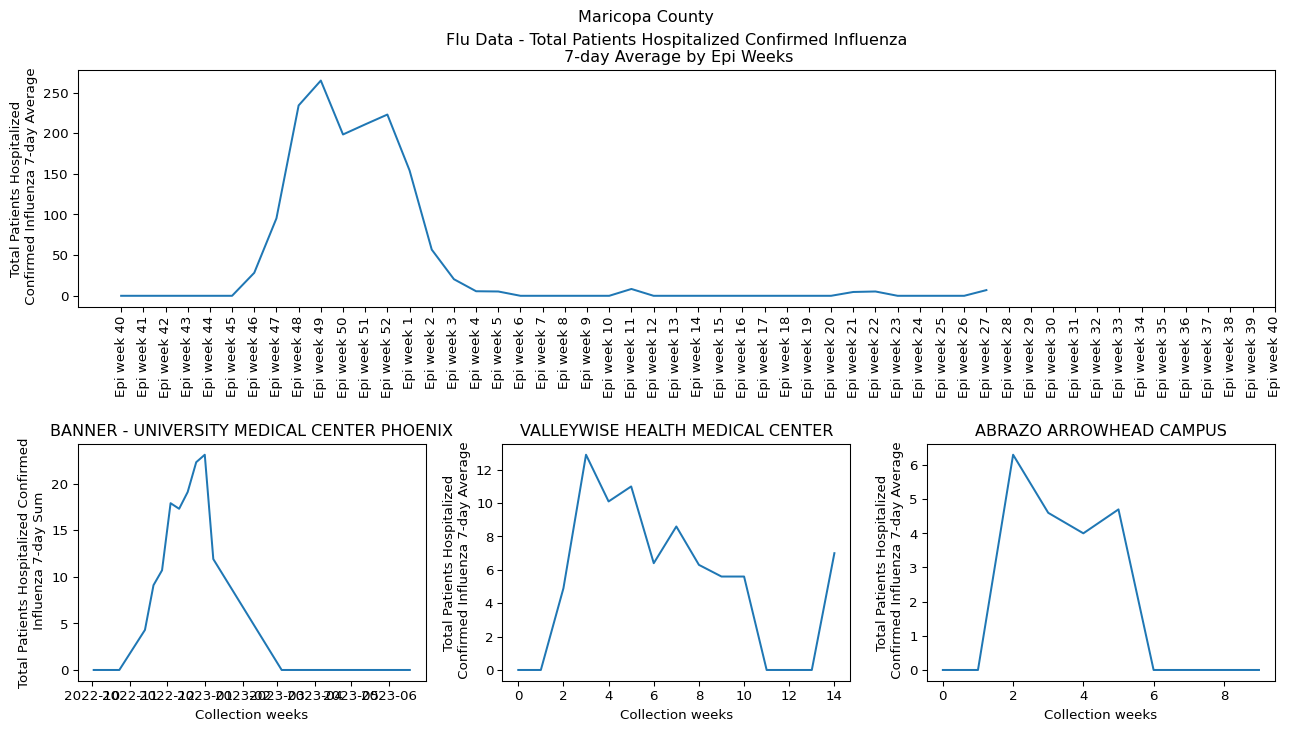

In [202]:
# Get the epi weeks starting from Epi Week 40
epi_weeks_40_52 = list(range(40, len(flu_grouped) + 13))
epi_weeks_1_40 = list(range(1, 41))  # Adjusted the end value to include 40

# Format the tick labels as "Epi week n"
custom_tick_labels = [*epi_weeks_40_52, *epi_weeks_1_40]

# Set the x-axis tick positions and labels
epi_weeks_40_52 = list(range(40, len(flu_grouped) + 13))
epi_weeks_1_40 = list(range(1, 41))
xtick_positions = [*epi_weeks_40_52, *epi_weeks_1_40]
xtick_labels = ['Epi week {}'.format(i) for i in xtick_positions]

fig = plt.figure(figsize=(13.33, 7.5), dpi=96, constrained_layout=True)
fig.suptitle('Maricopa County')

spec = fig.add_gridspec(2, 3)
ax0 = fig.add_subplot(spec[0, :])
ax0.plot(flu_grouped['total_patients_hospitalized_confirmed_influenza_7_day_avg'])
ax0.set_ylabel('Total Patients Hospitalized\n Confirmed Influenza 7-day Average')
ax0.set_xlabel(' ')
ax0.set_title('Flu Data - Total Patients Hospitalized Confirmed Influenza\n 7-day Average by Epi Weeks')

# Use modulo operator to wrap the x-axis values between 40 and 52
ax0.set_xticks(range(len(xtick_labels)))
ax0.set_xticklabels(xtick_labels, rotation='vertical')

# Create subplots for census blocks
ax10 = fig.add_subplot(spec[1, 0])
ax10.plot(hospital_1_grouped['collection_week'], hospital_1_grouped['total_patients_hospitalized_confirmed_influenza_7_day_avg'])
ax10.set_ylabel('Total Patients Hospitalized Confirmed\n Influenza 7-day Sum')
ax10.set_xlabel('Collection weeks')
ax10.set_title('BANNER - UNIVERSITY MEDICAL CENTER PHOENIX')

ax11 = fig.add_subplot(spec[1, 1])
ax11.plot(hospital_2_grouped['total_patients_hospitalized_confirmed_influenza_7_day_avg'])
ax11.set_ylabel('Total Patients Hospitalized\n Confirmed Influenza 7-day Average')
ax11.set_xlabel('Collection weeks')
ax11.set_title('VALLEYWISE HEALTH MEDICAL CENTER')

ax12 = fig.add_subplot(spec[1, 2])
ax12.plot(hospital_3_grouped['total_patients_hospitalized_confirmed_influenza_7_day_avg'])
ax12.set_ylabel('Total Patients Hospitalized\n Confirmed Influenza 7-day Average')
ax12.set_xlabel('Collection weeks')
ax12.set_title('ABRAZO ARROWHEAD CAMPUS')

plt.savefig(dir + '/plots/Az_data/agg_7_day_avg_hospitials.png', dpi=300, bbox_inches='tight')
plt.show()



In [ ]:
# Get the epi weeks starting from Epi Week 40
epi_weeks_40_52 = list(range(40, len(flu_grouped) + 13))
epi_weeks_1_40 = list(range(1, 41))  # Adjusted the end value to include 40

# Format the tick labels as "Epi week n"
custom_tick_labels = [*epi_weeks_40_52, *epi_weeks_1_40]

# Set the x-axis tick positions and labels
epi_weeks_40_52 = list(range(40, len(flu_grouped) + 13))
epi_weeks_1_40 = list(range(1, 41))
xtick_positions = [*epi_weeks_40_52, *epi_weeks_1_40]
xtick_labels = ['Epi week {}'.format(i) for i in xtick_positions]

fig = plt.figure(figsize=(13.33, 7.5), dpi=96, constrained_layout=True)
fig.suptitle('Maricopa County')

spec = fig.add_gridspec(2, 3)
ax0 = fig.add_subplot(spec[0, :])
ax0.plot(flu_grouped['previous_day_admission_influenza_confirmed_7_day_sum'])
ax0.set_ylabel('Previous Day Admission Influenza\n Confirmed 7-day Sum')
ax0.set_xlabel(' ')
ax0.set_title('Flu Data - Previous Day Admission Influenza Confirmed\n 7-day Sum by Epi Weeks')

# Use modulo operator to wrap the x-axis values between 40 and 52
ax0.set_xticks(range(len(xtick_labels)))
ax0.set_xticklabels(xtick_labels, rotation='vertical')

# Create subplots for census blocks
ax10 = fig.add_subplot(spec[1, 0])
ax10.plot(hospital_1_grouped['previous_day_admission_influenza_confirmed_7_day_sum'])
ax10.set_ylabel('Previous Day Admission Influenza\n Confirmed 7-day Sum')
ax10.set_xlabel('Collection weeks')
ax10.set_title('BANNER - UNIVERSITY MEDICAL CENTER PHOENIX')

ax11 = fig.add_subplot(spec[1, 1])
ax11.plot(hospital_2_grouped['previous_day_admission_influenza_confirmed_7_day_sum'])
ax11.set_ylabel('Previous Day Admission Influenza\n Confirmed 7-day Sum')
ax11.set_xlabel('Collection weeks')
ax11.set_title('VALLEYWISE HEALTH MEDICAL CENTER')

ax12 = fig.add_subplot(spec[1, 2])
ax12.plot(hospital_3_grouped['previous_day_admission_influenza_confirmed_7_day_sum'])
ax12.set_ylabel('Previous Day Admission Influenza\n Confirmed 7-day Sum')
ax12.set_xlabel('Collection weeks')
ax12.set_title('ABRAZO ARROWHEAD CAMPUS')

plt.savefig(dir + '/plots/Az_data/agg_previous_day_admission_influenza.png', dpi=300, bbox_inches='tight')
plt.show()


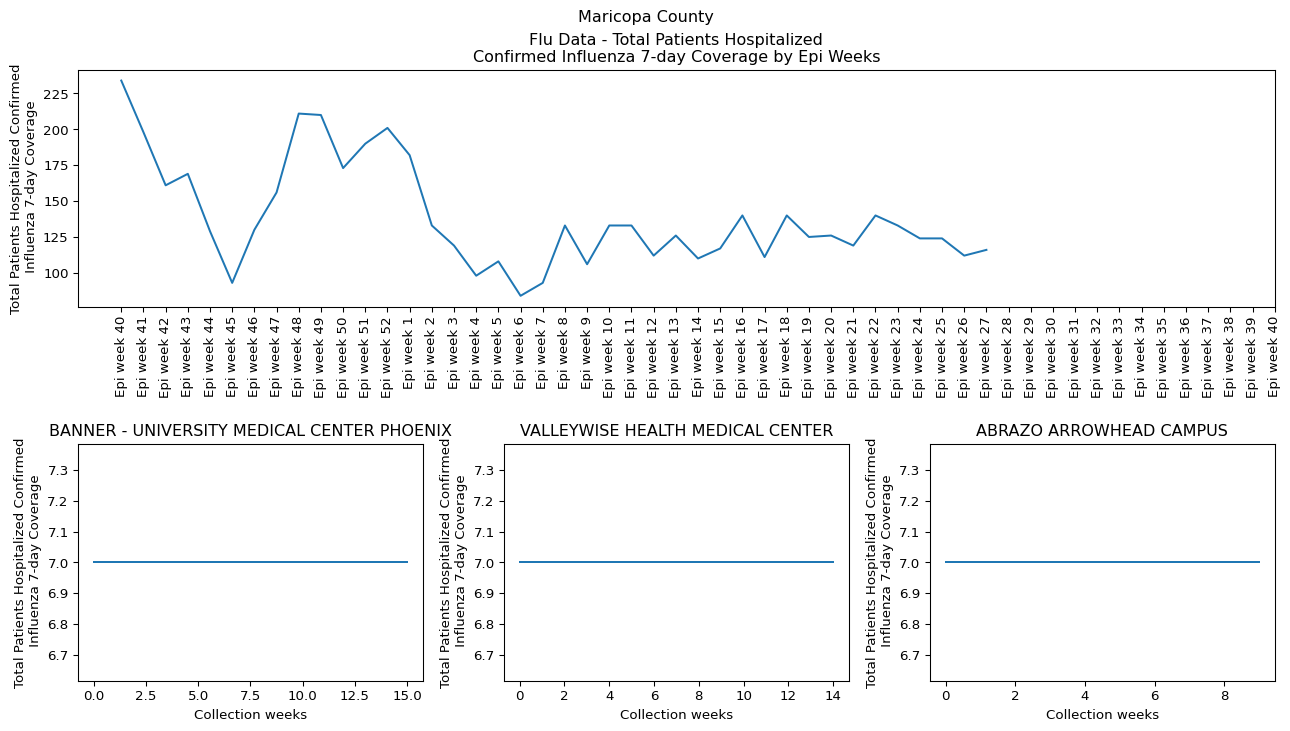

In [197]:
# Get the epi weeks starting from Epi Week 40
epi_weeks_40_52 = list(range(40, len(flu_grouped) + 13))
epi_weeks_1_40 = list(range(1, 41))  # Adjusted the end value to include 40

# Format the tick labels as "Epi week n"
custom_tick_labels = [*epi_weeks_40_52, *epi_weeks_1_40]

# Set the x-axis tick positions and labels
epi_weeks_40_52 = list(range(40, len(flu_grouped) + 13))
epi_weeks_1_40 = list(range(1, 41))
xtick_positions = [*epi_weeks_40_52, *epi_weeks_1_40]
xtick_labels = ['Epi week {}'.format(i) for i in xtick_positions]

fig = plt.figure(figsize=(13.33, 7.5), dpi=96, constrained_layout=True)
fig.suptitle('Maricopa County')

spec = fig.add_gridspec(2, 3)
ax0 = fig.add_subplot(spec[0, :])
ax0.plot(flu_grouped['total_patients_hospitalized_confirmed_influenza_7_day_coverage'])
ax0.set_ylabel('Total Patients Hospitalized Confirmed\n Influenza 7-day Coverage')
ax0.set_xlabel(' ')
ax0.set_title('Flu Data - Total Patients Hospitalized\nConfirmed Influenza 7-day Coverage by Epi Weeks')

# Use modulo operator to wrap the x-axis values between 40 and 52
ax0.set_xticks(range(len(xtick_labels)))
ax0.set_xticklabels(xtick_labels, rotation='vertical')

# Create subplots for census blocks
ax10 = fig.add_subplot(spec[1, 0])
ax10.plot(hospital_1_grouped['total_patients_hospitalized_confirmed_influenza_7_day_coverage'])
ax10.set_ylabel('Total Patients Hospitalized Confirmed\n Influenza 7-day Coverage')
ax10.set_xlabel('Collection weeks')
ax10.set_title('BANNER - UNIVERSITY MEDICAL CENTER PHOENIX')

ax11 = fig.add_subplot(spec[1, 1])
ax11.plot(hospital_2_grouped['total_patients_hospitalized_confirmed_influenza_7_day_coverage'])
ax11.set_ylabel('Total Patients Hospitalized Confirmed\n Influenza 7-day Coverage')
ax11.set_xlabel('Collection weeks')
ax11.set_title('VALLEYWISE HEALTH MEDICAL CENTER')

ax12 = fig.add_subplot(spec[1, 2])
ax12.plot(hospital_3_grouped['total_patients_hospitalized_confirmed_influenza_7_day_coverage'])
ax12.set_ylabel('Total Patients Hospitalized Confirmed\n Influenza 7-day Coverage')
ax12.set_xlabel('Collection weeks')
ax12.set_title('ABRAZO ARROWHEAD CAMPUS')

plt.savefig(dir + '/plots/Az_data/agg_influenza_7_day_coverage.png', dpi=300, bbox_inches='tight')
plt.show()


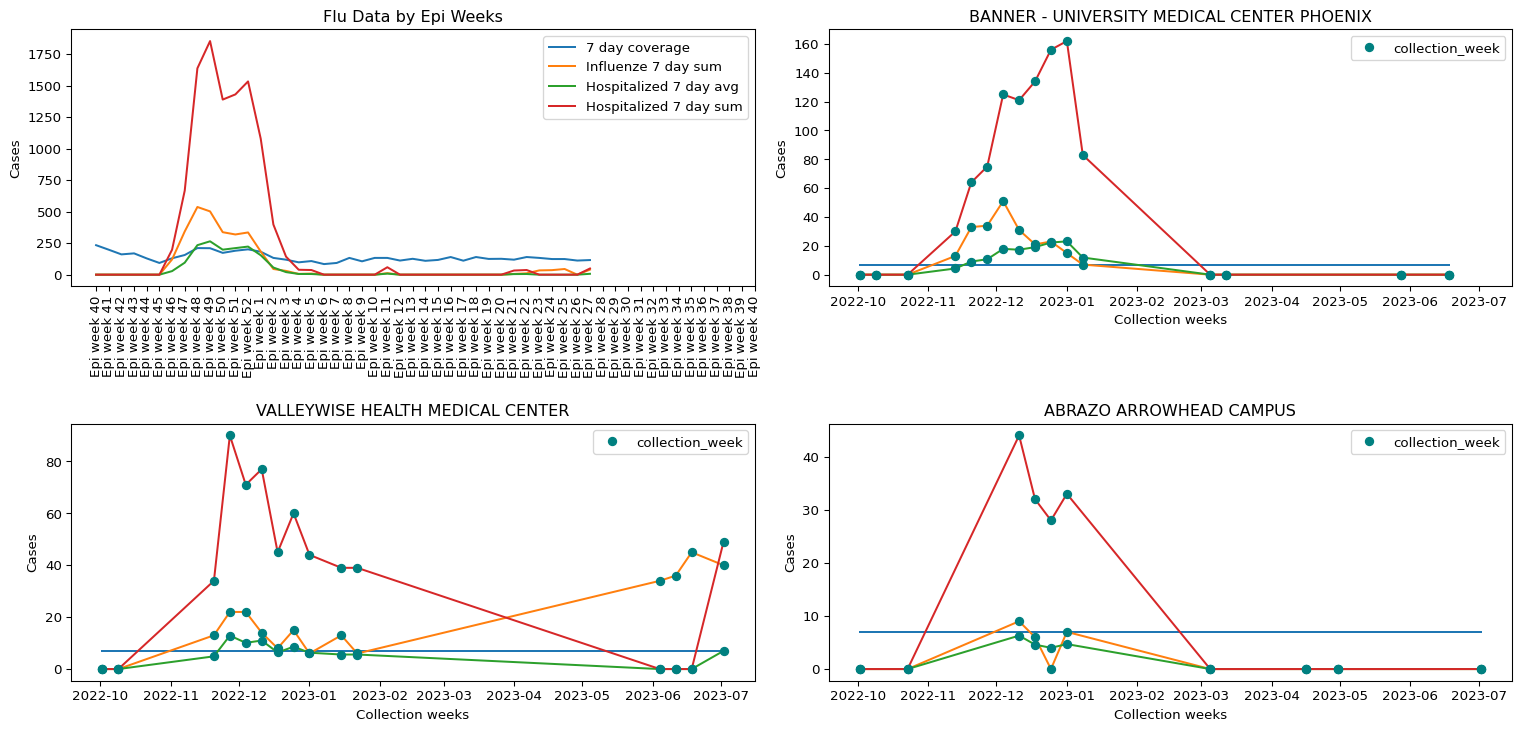

In [277]:
# Get the epi weeks starting from Epi Week 40
epi_weeks_40_52 = list(range(40, len(flu_grouped) + 13))
epi_weeks_1_40 = list(range(1, 41))  # Adjusted the end value to include 40

# Format the tick labels as "Epi week n"
custom_tick_labels = [*epi_weeks_40_52, *epi_weeks_1_40]

# Set the x-axis tick positions and labels
epi_weeks_40_52 = list(range(40, len(flu_grouped) + 13))
epi_weeks_1_40 = list(range(1, 41))
xtick_positions = [*epi_weeks_40_52, *epi_weeks_1_40]
xtick_labels = ['Epi week {}'.format(i) for i in xtick_positions]

fig = plt.figure(figsize=(30, 7.5), dpi=96, constrained_layout=True)

spec = fig.add_gridspec(2, 4)
ax0 = fig.add_subplot(spec[0, 0])
ax10 = fig.add_subplot(spec[0, 1])
ax11 = fig.add_subplot(spec[1, 0])
ax12 = fig.add_subplot(spec[1, 1])

ax0.plot(flu_grouped['total_patients_hospitalized_confirmed_influenza_7_day_coverage'],label= '7 day coverage')
ax0.plot(flu_grouped['previous_day_admission_influenza_confirmed_7_day_sum'],label= 'Influenze 7 day sum')
ax0.plot(flu_grouped['total_patients_hospitalized_confirmed_influenza_7_day_avg'], label= 'Hospitalized 7 day avg')
ax0.plot(flu_grouped['total_patients_hospitalized_confirmed_influenza_7_day_sum'], label= 'Hospitalized 7 day sum')

# Use modulo operator to wrap the x-axis values between 40 and 52
ax0.set_xticks(range(len(xtick_labels)))
ax0.set_xticklabels(xtick_labels, rotation='vertical')

ax0.set_ylabel('Cases')
ax0.set_xlabel(' ')
ax0.set_title('Flu Data by Epi Weeks')
ax0.legend()

# Create subplots for census blocks

ax10.plot(hospital_1_grouped['collection_week'], hospital_1_grouped['total_patients_hospitalized_confirmed_influenza_7_day_coverage'])
ax10.plot(hospital_1_grouped['collection_week'], hospital_1_grouped['previous_day_admission_influenza_confirmed_7_day_sum'])
ax10.plot(hospital_1_grouped['collection_week'], hospital_1_grouped['total_patients_hospitalized_confirmed_influenza_7_day_avg'])
ax10.plot(hospital_1_grouped['collection_week'], hospital_1_grouped['total_patients_hospitalized_confirmed_influenza_7_day_sum'])

ax10.plot(hospital_1_grouped['collection_week'], hospital_1_grouped['previous_day_admission_influenza_confirmed_7_day_sum'],'o',color = 'teal', label = "collection_week")
ax10.plot(hospital_1_grouped['collection_week'], hospital_1_grouped['total_patients_hospitalized_confirmed_influenza_7_day_avg'],'o',color = 'teal')
ax10.plot(hospital_1_grouped['collection_week'], hospital_1_grouped['total_patients_hospitalized_confirmed_influenza_7_day_sum'],'o',color = 'teal')

line1, = ax10.plot(flu_grouped['collection_week'], flu_grouped['count'], color = 'white')
line1.remove()

ax10.set_ylabel('Cases')
ax10.set_xlabel('Collection weeks')
ax10.set_title('BANNER - UNIVERSITY MEDICAL CENTER PHOENIX')
ax10.legend()

ax11.plot(hospital_2_grouped['collection_week'], hospital_2_grouped['total_patients_hospitalized_confirmed_influenza_7_day_coverage'])
ax11.plot(hospital_2_grouped['collection_week'], hospital_2_grouped['previous_day_admission_influenza_confirmed_7_day_sum'])
ax11.plot(hospital_2_grouped['collection_week'], hospital_2_grouped['total_patients_hospitalized_confirmed_influenza_7_day_avg'])
ax11.plot(hospital_2_grouped['collection_week'], hospital_2_grouped['total_patients_hospitalized_confirmed_influenza_7_day_sum'])

ax11.plot(hospital_2_grouped['collection_week'], hospital_2_grouped['previous_day_admission_influenza_confirmed_7_day_sum'],'o',color = 'teal', label = "collection_week")
ax11.plot(hospital_2_grouped['collection_week'], hospital_2_grouped['total_patients_hospitalized_confirmed_influenza_7_day_avg'],'o',color = 'teal')
ax11.plot(hospital_2_grouped['collection_week'], hospital_2_grouped['total_patients_hospitalized_confirmed_influenza_7_day_sum'],'o',color = 'teal')

line2, = ax11.plot(flu_grouped['collection_week'], flu_grouped['count'], color = 'white')
line2.remove()

ax11.set_ylabel('Cases')
ax11.set_xlabel('Collection weeks')
ax11.set_title('VALLEYWISE HEALTH MEDICAL CENTER')
ax11.legend()

ax12.plot(hospital_3_grouped['collection_week'], hospital_3_grouped['total_patients_hospitalized_confirmed_influenza_7_day_coverage'])
ax12.plot(hospital_3_grouped['collection_week'], hospital_3_grouped['previous_day_admission_influenza_confirmed_7_day_sum'])
ax12.plot(hospital_3_grouped['collection_week'], hospital_3_grouped['total_patients_hospitalized_confirmed_influenza_7_day_avg'])
ax12.plot(hospital_3_grouped['collection_week'], hospital_3_grouped['total_patients_hospitalized_confirmed_influenza_7_day_sum'])

ax12.plot(hospital_3_grouped['collection_week'], hospital_3_grouped['previous_day_admission_influenza_confirmed_7_day_sum'],'o',color = 'teal', label = "collection_week")
ax12.plot(hospital_3_grouped['collection_week'], hospital_3_grouped['total_patients_hospitalized_confirmed_influenza_7_day_avg'],'o',color = 'teal')
ax12.plot(hospital_3_grouped['collection_week'], hospital_3_grouped['total_patients_hospitalized_confirmed_influenza_7_day_sum'],'o',color = 'teal')

line3, = ax12.plot(flu_grouped['collection_week'], flu_grouped['count'], color = 'white')
line3.remove()

ax12.set_ylabel('Cases')
ax12.set_xlabel('Collection weeks')
ax12.set_title('ABRAZO ARROWHEAD CAMPUS')
ax12.legend()

plt.savefig(dir + '/plots/Az_data/agg_data.png', dpi=300, bbox_inches='tight')
plt.show()


In [274]:
hospital_1

,hospital_pk,zip,hospital_name,fips_code,address,collection_week,total_patients_hospitalized_confirmed_influenza_7_day_avg,total_patients_hospitalized_confirmed_influenza_7_day_sum,total_patients_hospitalized_confirmed_influenza_7_day_coverage,previous_day_admission_influenza_confirmed_7_day_sum
109,030002,85006.0,BANNER - UNIVERSITY MEDICAL CENTER PHOENIX,4013.0,1111 EAST MCDOWELL ROAD,2022-12-04,17.9,125.0,7,51.0
1635,030002,85006.0,BANNER - UNIVERSITY MEDICAL CENTER PHOENIX,4013.0,1111 EAST MCDOWELL ROAD,2022-12-25,22.3,156.0,7,23.0
2192,030002,85006.0,BANNER - UNIVERSITY MEDICAL CENTER PHOENIX,4013.0,1111 EAST MCDOWELL ROAD,2023-01-01,23.1,162.0,7,15.0
2367,030002,85006.0,BANNER - UNIVERSITY MEDICAL CENTER PHOENIX,4013.0,1111 EAST MCDOWELL ROAD,2023-03-12,0.0,0.0,7,0.0
3110,030002,85006.0,BANNER - UNIVERSITY MEDICAL CENTER PHOENIX,4013.0,1111 EAST MCDOWELL ROAD,2023-05-28,0.0,0.0,7,0.0
3719,030002,85006.0,BANNER - UNIVERSITY MEDICAL CENTER PHOENIX,4013.0,1111 EAST MCDOWELL ROAD,2022-11-13,4.3,30.0,7,13.0
3889,030002,85006.0,BANNER - UNIVERSITY MEDICAL CENTER PHOENIX,4013.0,1111 EAST MCDOWELL ROAD,2023-01-08,11.9,83.0,7,7.0
4482,030002,85006.0,BANNER - UNIVERSITY MEDICAL CENTER PHOENIX,4013.0,1111 EAST MCDOWELL ROAD,2022-12-11,17.3,121.0,7,31.0
4518,030002,85006.0,BANNER - UNIVERSITY MEDICAL CENTER PHOENIX,4013.0,1111 EAST MCDOWELL ROAD,2022-11-27,10.7,75.0,7,34.0
4741,030002,85006.0,BANNER - UNIVERSITY MEDICAL CENTER PHOENIX,4013.0,1111 EAST MCDOWELL ROAD,2022-11-20,9.1,64.0,7,33.0


(array([19266., 19297., 19327., 19358., 19389., 19417., 19448., 19478.,
        19509., 19539.]),
 [Text(19266.0, 0, '2022-10'),
  Text(19297.0, 0, '2022-11'),
  Text(19327.0, 0, '2022-12'),
  Text(19358.0, 0, '2023-01'),
  Text(19389.0, 0, '2023-02'),
  Text(19417.0, 0, '2023-03'),
  Text(19448.0, 0, '2023-04'),
  Text(19478.0, 0, '2023-05'),
  Text(19509.0, 0, '2023-06'),
  Text(19539.0, 0, '2023-07')])

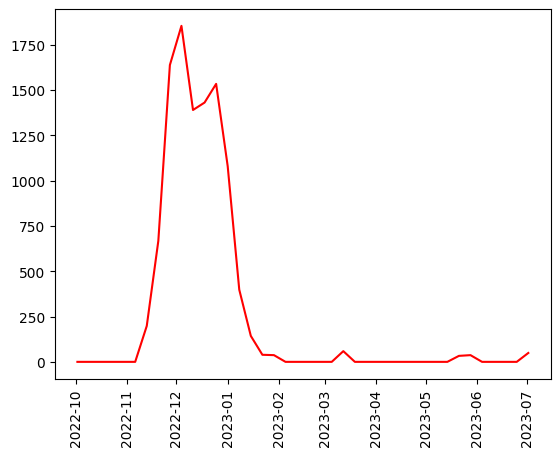

In [272]:
plt.plot(flu_grouped['collection_week'], flu_grouped['total_patients_hospitalized_confirmed_influenza_7_day_sum'], color = 'red')
plt.xticks(rotation=90)

# Spline

In [ ]:

# Plots sirh model
for i in range(4):
    sirh_compartment.plot(kind='line',
            y= sirh[i],
            ylabel="population", 
            logy=True,
            color=color[i], 
            ax=axes[1],
            title = 'SIRH mdoel') 
    Events.plot(kind='line', 
            y=event_rate[i],
            color=color[i], 
            ax=axes[0],
            title = 'Event Rates')    

In [135]:
test = geo_df.reset_index()
#test = test.dropna(subset=['beta'], inplace=True)
test.dropna(subset=['beta'], inplace=True

In [136]:
test.dropna(subset=['beta'], inplace=True)

In [137]:
test['beta']

0       0.321368
1       0.316722
2       0.309859
3       0.313548
4       0.318366
          ...   
2489    0.369537
2490    0.368833
2491    0.310591
2492    0.373718
2493    0.349806
Name: beta, Length: 2494, dtype: float64

In [290]:
hospital_3_grouped = hospital_3_grouped.reset_index()

In [161]:
Events = Events.reset_index()
hospital_3_grouped['collection_week'], hospital_3_grouped['previous_day_admission_influenza_confirmed_7_day_sum']

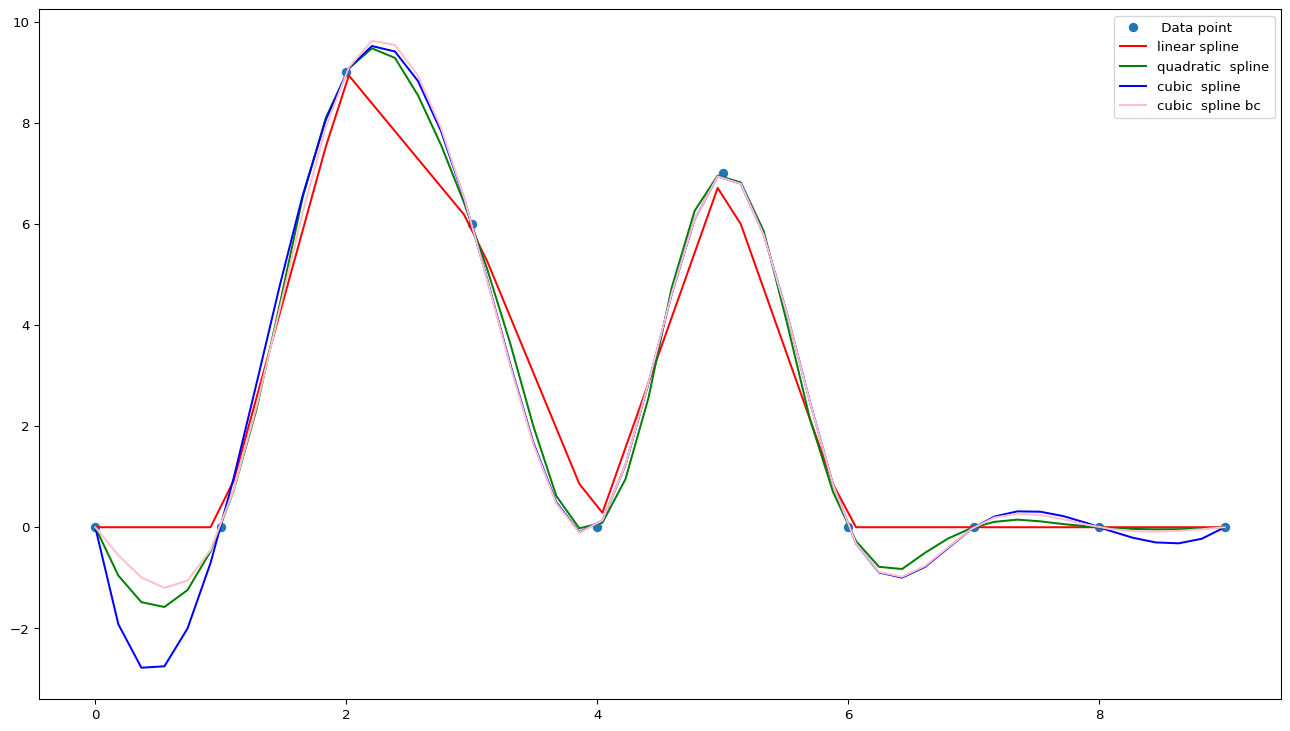

In [291]:
from scipy.interpolate import interp1d, CubicSpline
fig = plt.figure(figsize=(13.33, 7.5), dpi=96, constrained_layout=True)

x = hospital_3_grouped['index']
y = hospital_3_grouped['previous_day_admission_influenza_confirmed_7_day_sum']

x_interp = np.linspace(np.min(x), np.max(x), 50)

# 1D linear Spline Interpolation
y_linear = interp1d(x,y)

# 1D Quadratic Spline Interpolation 
y_quadratic = interp1d(x,y, kind = "quadratic")

# 1D Cubic Spline Interpolation 
y_cubic= interp1d(x,y, kind = "cubic")

# 1D Cubic Spline Interpolation w/ bc
y_cubicbc = CubicSpline(x,y, bc_type = "natural")

plt.plot(x,y, "o", label = " Data point")
plt.plot(x_interp, y_linear(x_interp), "red", label = "linear spline")
plt.plot(x_interp, y_quadratic(x_interp), "green", label = "quadratic  spline")
plt.plot(x_interp, y_cubic(x_interp), "blue", label = "cubic  spline")
plt.plot(x_interp, y_cubicbc(x_interp), "pink", label = "cubic  spline bc")


plt.legend()
plt.show()

In [181]:
from scipy.interpolate import BSpline
k = 3
t = [0, 1, 2, 3, 4, 5, 6,7]
c = [-1, 2, 0, -1]
spl = BSpline(t, c, k)

In [182]:
def B(x, k, i, t):
   if k == 0:
      return 1.0 if t[i] <= x < t[i+1] else 0.0
   if t[i+k] == t[i]:
      c1 = 0.0
   else:
      c1 = (x - t[i])/(t[i+k] - t[i]) * B(x, k-1, i, t)
   if t[i+k+1] == t[i+1]:
      c2 = 0.0
   else:
      c2 = (t[i+k+1] - x)/(t[i+k+1] - t[i+1]) * B(x, k-1, i+1, t)
   return c1 + c2
def bspline(x, t, c, k):
   n = len(t) - k - 1
   assert (n >= k+1) and (len(c) >= n)
   return sum(c[i] * B(x, k, i, t) for i in range(n))

In [164]:
bspline(2.5, t, c, k)

1.375

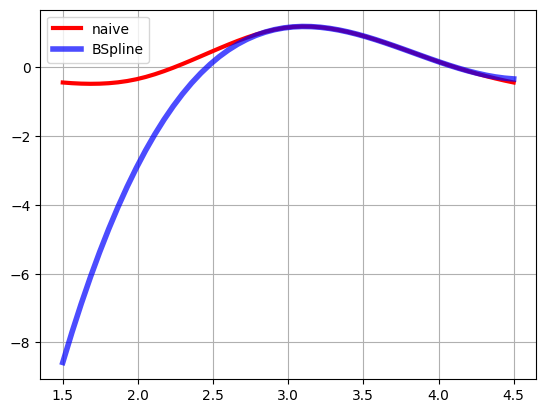

In [183]:
fig, ax = plt.subplots()
xx = np.linspace(1.5, 4.5, 50)
ax.plot(xx, [bspline(x, t, c ,k) for x in xx], 'r-', lw=3, label='naive')
ax.plot(xx, spl(xx), 'b-', lw=4, alpha=0.7, label='BSpline')
ax.grid(True)
ax.legend(loc='best')
plt.show()